# DEX vs CEX Price Discovery Analysis

This notebook analyzes the lead-lag relationship between DEX (Uniswap V3) and CEX (Binance) for ETH/USDT using different bar sampling methods:
1. **Time bars** (4-hour candles)
2. Volume bars (TBD)
3. Tick bars (TBD)

## Section 1: Setup & Data Loading

In [52]:
# Install dependencies if needed
%pip install pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-whitegrid')

In [54]:
# Load DEX data (Uniswap V3 mainnet)
dex_raw = pd.read_parquet('eth_usdt_dex_oct2025_mainnet.parquet')
print(f'DEX raw data: {len(dex_raw):,} trades')
dex_raw.head()

DEX raw data: 695,949 trades


,id,timestamp,eth_amount,usdt_amount,price_usdt_per_eth,pool,symbolA,symbolB,qtyA,qtyB,date
0,0x1ead61ecbb172717028a86393370e49186f3de023149...,1759276811,-1.000194,4147.022412,4146.216013,0x11b815efb8f581194ae79006d24e0d814b7697f6,WETH,USDT,-1.000194,4147.022412,20251001
1,0xbb5339627b16b5f3423a9284d1d4429210b40b5a9148...,1759276811,-2.242273,9296.132289,4145.851527,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,-2.242273,9296.132289,20251001
2,0xda1732cb4fddba3f5cdf860b51901f94f4209acf7ff7...,1759276811,-11.896334,49324.643911,4146.205526,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,-11.896334,49324.643911,20251001
3,0xf92a1f6072d3ff7be2c9fcae84fdc24fe5f3b5e4e868...,1759276811,0.034648,-142.805219,4121.601882,0x4e68ccd3e89f51c3074ca5072bbac773960dfa36,WETH,USDT,0.034648,-142.805219,20251001
4,0xcdae92d918467ebad62243c8ee7a0498cf88e3c709d6...,1759276823,0.167588,-694.762010,4145.654251,0xc7bbec68d12a0d1830360f8ec58fa599ba1b0e9b,WETH,USDT,0.167588,-694.762010,20251001


In [55]:
# Load CEX data (Binance) - this may take a minute due to file size
cex_raw = pd.read_csv(
    'ETHUSDT-aggTrades-2025-10.csv',
    header=None,
    names=['agg_trade_id', 'price', 'quantity', 'first_trade_id', 
           'last_trade_id', 'timestamp', 'is_buyer_maker', 'is_best_match']
)
print(f'CEX raw data: {len(cex_raw):,} trades')
cex_raw.head()

CEX raw data: 50,227,413 trades


,agg_trade_id,price,quantity,first_trade_id,last_trade_id,timestamp,is_buyer_maker,is_best_match
0,1720750793,4145.15,0.0099,2902981421,2902981421,1759276800336276,False,True
1,1720750794,4145.15,2.0509,2902981422,2902981434,1759276800962468,False,True
2,1720750795,4145.16,0.2192,2902981435,2902981440,1759276800962468,False,True
3,1720750796,4145.17,0.0133,2902981441,2902981443,1759276800962468,False,True
4,1720750797,4145.18,0.0033,2902981444,2902981445,1759276800962468,False,True


## Section 2: Build 4-Hour Candles

### 2.1 DEX Candles

In [56]:
# Prepare DEX data
dex = dex_raw.copy()
dex['datetime'] = pd.to_datetime(dex['timestamp'], unit='s')
dex['abs_eth_volume'] = dex['eth_amount'].abs()
dex['abs_usdt_volume'] = dex['usdt_amount'].abs()

# Filter out only dust trades (keep all real trades including artifacts)
min_eth_volume = 0.01  # Exclude trades < 0.01 ETH

before_filter = len(dex)
dex = dex[dex['abs_eth_volume'] >= min_eth_volume]
after_filter = len(dex)

print(f"Filtered out {before_filter - after_filter:,} dust trades ({100*(before_filter - after_filter)/before_filter:.2f}%)")
print(f"Remaining trades: {after_filter:,}")

dex = dex.set_index('datetime').sort_index()

print(f"DEX time range: {dex.index.min()} to {dex.index.max()}")
print(f"DEX price range: {dex['price_usdt_per_eth'].min():.2f} - {dex['price_usdt_per_eth'].max():.2f}")

Filtered out 84,856 dust trades (12.19%)
Remaining trades: 611,093
DEX time range: 2025-10-01 00:00:11 to 2025-11-01 02:59:59
DEX price range: 43.83 - 7308.27


In [57]:
# Build 4-hour DEX candles
dex_4h = dex.resample('4h').agg({
    'price_usdt_per_eth': ['first', 'max', 'min', 'last'],
    'abs_eth_volume': 'sum',
    'abs_usdt_volume': 'sum'
})

# Flatten column names
dex_4h.columns = ['open', 'high', 'low', 'close', 'volume_eth', 'volume_usdt']

# Compute VWAP
dex_vwap = dex.resample('4h').apply(
    lambda x: np.average(x['price_usdt_per_eth'], weights=x['abs_eth_volume']) 
    if x['abs_eth_volume'].sum() > 0 else np.nan
)
dex_4h['vwap'] = dex_vwap

# Count trades per candle
dex_4h['trade_count'] = dex.resample('4h').size()

# Drop empty candles
dex_4h = dex_4h.dropna()

print(f"DEX 4h candles: {len(dex_4h)} bars")
dex_4h.head(10)

DEX 4h candles: 187 bars


,open,high,low,close,volume_eth,volume_usdt,vwap,trade_count
datetime,,,,,,,,
2025-10-01 00:00:00,4146.216013,4174.170034,3882.495109,4130.294606,5163.058845,2.131879e+07,4129.100342,2610
2025-10-01 04:00:00,4129.280600,4187.790080,4057.941306,4147.110927,2934.675546,1.214456e+07,4138.296429,2875
2025-10-01 08:00:00,4146.373130,4329.094391,4123.371330,4295.039499,12622.192389,5.373999e+07,4257.579768,3872
2025-10-01 12:00:00,4298.161876,4558.637436,4176.248098,4327.538676,11287.924566,4.867230e+07,4311.890745,2626
2025-10-01 16:00:00,4328.341432,4565.837404,4253.788391,4333.368872,7367.864986,3.190963e+07,4330.919630,2467
2025-10-01 20:00:00,4335.043644,4541.360054,4244.320009,4346.301203,8820.333810,3.823787e+07,4335.195009,2777
2025-10-02 00:00:00,4347.802076,4596.281824,4153.151773,4378.049072,13875.251588,6.067563e+07,4372.939267,3681
2025-10-02 04:00:00,4376.766904,7308.273168,4314.968555,4376.254033,11779.703611,5.234560e+07,4443.711175,2922
2025-10-02 08:00:00,4376.160954,4409.090098,4334.743039,4379.722304,4704.832940,2.062163e+07,4383.074214,2386


### 2.2 CEX Candles

In [58]:
# Prepare CEX data
cex = cex_raw.copy()
cex['datetime'] = pd.to_datetime(cex['timestamp'], unit='us')  # Binance uses microseconds
cex['trade_value'] = cex['price'] * cex['quantity']
cex = cex.set_index('datetime').sort_index()

print(f"CEX time range: {cex.index.min()} to {cex.index.max()}")

CEX time range: 2025-10-01 00:00:00.336276 to 2025-10-31 23:59:59.896567


In [59]:
# Build 4-hour CEX candles
cex_4h = cex.resample('4h').agg({
    'price': ['first', 'max', 'min', 'last'],
    'quantity': 'sum',
    'trade_value': 'sum'
})

# Flatten column names
cex_4h.columns = ['open', 'high', 'low', 'close', 'volume_eth', 'volume_usdt']

# Compute VWAP
cex_4h['vwap'] = cex_4h['volume_usdt'] / cex_4h['volume_eth']

# Count trades per candle
cex_4h['trade_count'] = cex.resample('4h').size()

# Drop empty candles
cex_4h = cex_4h.dropna()

print(f"CEX 4h candles: {len(cex_4h)} bars")
cex_4h.head(10)

CEX 4h candles: 186 bars


,open,high,low,close,volume_eth,volume_usdt,vwap,trade_count
datetime,,,,,,,,
2025-10-01 00:00:00,4145.15,4174.63,4124.12,4128.66,48730.6970,2.021777e+08,4148.878580,129754
2025-10-01 04:00:00,4128.65,4156.79,4123.08,4145.80,40423.0346,1.673896e+08,4140.945771,127793
2025-10-01 08:00:00,4145.80,4329.00,4142.92,4298.20,174933.8930,7.469364e+08,4269.821024,327380
2025-10-01 12:00:00,4298.21,4344.00,4280.00,4327.23,97899.3215,4.221891e+08,4312.482312,278606
2025-10-01 16:00:00,4327.24,4340.00,4288.64,4334.53,79548.3980,3.439725e+08,4324.065926,168829
2025-10-01 20:00:00,4334.52,4355.46,4287.50,4348.03,65491.0381,2.830746e+08,4322.341158,136396
2025-10-02 00:00:00,4348.03,4399.11,4332.73,4376.30,100457.8046,4.393669e+08,4373.645799,227176
2025-10-02 04:00:00,4376.30,4423.35,4358.26,4375.78,100115.3105,4.392580e+08,4387.520766,151120
2025-10-02 08:00:00,4375.77,4395.98,4369.32,4378.93,35078.5550,1.537369e+08,4382.645718,92990


## Section 3: Merge & Align

In [60]:
# Merge DEX and CEX candles on timestamp
candles_4h = pd.merge(
    dex_4h[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    cex_4h[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex'),
    how='inner'
)

print(f"Aligned 4h candles: {len(candles_4h)} bars")
print(f"Time range: {candles_4h.index.min()} to {candles_4h.index.max()}")
candles_4h.head(10)

Aligned 4h candles: 186 bars
Time range: 2025-10-01 00:00:00 to 2025-10-31 20:00:00


,open_dex,high_dex,low_dex,close_dex,vwap_dex,volume_eth_dex,trade_count_dex,open_cex,high_cex,low_cex,close_cex,vwap_cex,volume_eth_cex,trade_count_cex
datetime,,,,,,,,,,,,,,
2025-10-01 00:00:00,4146.216013,4174.170034,3882.495109,4130.294606,4129.100342,5163.058845,2610,4145.15,4174.63,4124.12,4128.66,4148.878580,48730.6970,129754
2025-10-01 04:00:00,4129.280600,4187.790080,4057.941306,4147.110927,4138.296429,2934.675546,2875,4128.65,4156.79,4123.08,4145.80,4140.945771,40423.0346,127793
2025-10-01 08:00:00,4146.373130,4329.094391,4123.371330,4295.039499,4257.579768,12622.192389,3872,4145.80,4329.00,4142.92,4298.20,4269.821024,174933.8930,327380
2025-10-01 12:00:00,4298.161876,4558.637436,4176.248098,4327.538676,4311.890745,11287.924566,2626,4298.21,4344.00,4280.00,4327.23,4312.482312,97899.3215,278606
2025-10-01 16:00:00,4328.341432,4565.837404,4253.788391,4333.368872,4330.919630,7367.864986,2467,4327.24,4340.00,4288.64,4334.53,4324.065926,79548.3980,168829
2025-10-01 20:00:00,4335.043644,4541.360054,4244.320009,4346.301203,4335.195009,8820.333810,2777,4334.52,4355.46,4287.50,4348.03,4322.341158,65491.0381,136396
2025-10-02 00:00:00,4347.802076,4596.281824,4153.151773,4378.049072,4372.939267,13875.251588,3681,4348.03,4399.11,4332.73,4376.30,4373.645799,100457.8046,227176
2025-10-02 04:00:00,4376.766904,7308.273168,4314.968555,4376.254033,4443.711175,11779.703611,2922,4376.30,4423.35,4358.26,4375.78,4387.520766,100115.3105,151120
2025-10-02 08:00:00,4376.160954,4409.090098,4334.743039,4379.722304,4383.074214,4704.832940,2386,4375.77,4395.98,4369.32,4378.93,4382.645718,35078.5550,92990


In [61]:
# Quick stats
print("=== DEX Stats ===")
print(f"Avg volume per candle: {candles_4h['volume_eth_dex'].mean():,.1f} ETH")
print(f"Avg trades per candle: {candles_4h['trade_count_dex'].mean():,.0f}")
print()
print("=== CEX Stats ===")
print(f"Avg volume per candle: {candles_4h['volume_eth_cex'].mean():,.1f} ETH")
print(f"Avg trades per candle: {candles_4h['trade_count_cex'].mean():,.0f}")
print()
print("=== Price Comparison ===")
print(f"Mean DEX VWAP: ${candles_4h['vwap_dex'].mean():,.2f}")
print(f"Mean CEX VWAP: ${candles_4h['vwap_cex'].mean():,.2f}")
print(f"Mean spread (DEX - CEX): ${(candles_4h['vwap_dex'] - candles_4h['vwap_cex']).mean():,.2f}")

=== DEX Stats ===
Avg volume per candle: 10,304.8 ETH
Avg trades per candle: 3,277

=== CEX Stats ===
Avg volume per candle: 92,562.3 ETH
Avg trades per candle: 270,040

=== Price Comparison ===
Mean DEX VWAP: $4,103.14
Mean CEX VWAP: $4,113.60
Mean spread (DEX - CEX): $-10.47


## Section 4: Visualization

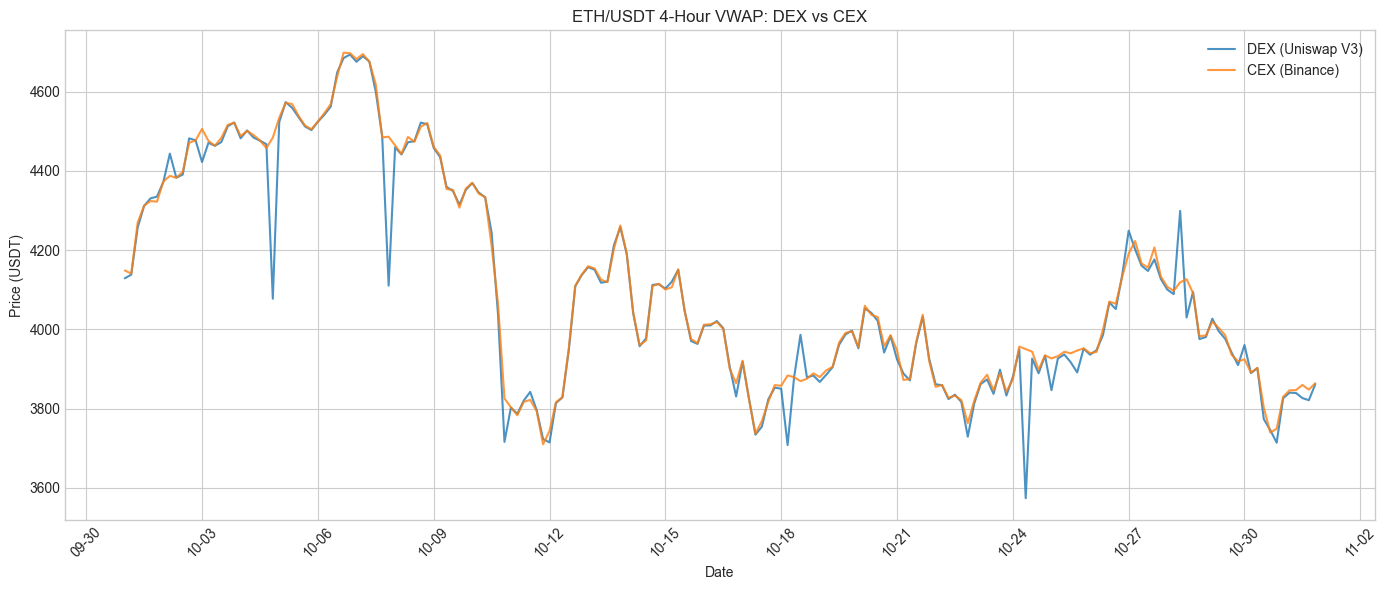

In [62]:
# Plot 1: DEX vs CEX VWAP prices over time
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(candles_4h.index, candles_4h['vwap_dex'], label='DEX (Uniswap V3)', alpha=0.8)
ax.plot(candles_4h.index, candles_4h['vwap_cex'], label='CEX (Binance)', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Price (USDT)')
ax.set_title('ETH/USDT 4-Hour VWAP: DEX vs CEX')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

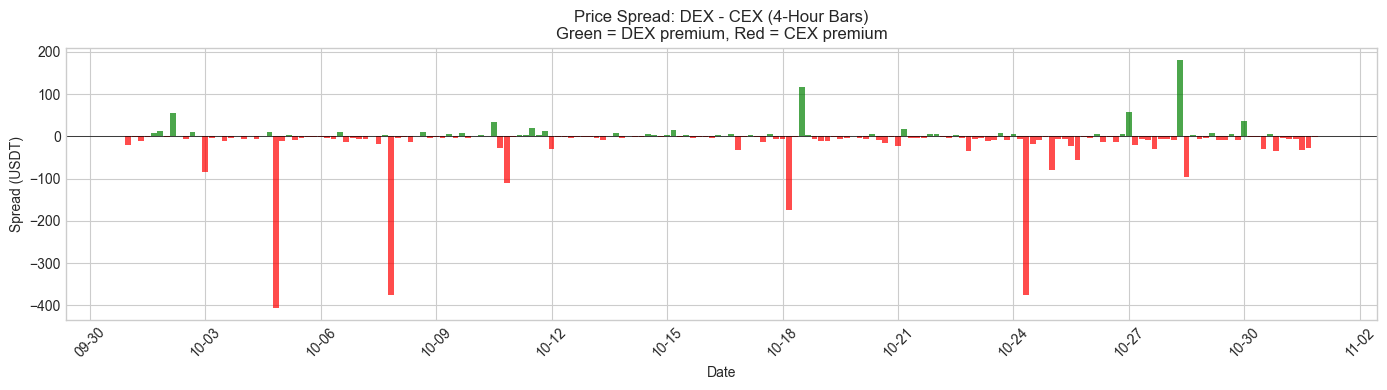

Spread stats: mean=-10.47, std=55.47, min=-406.51, max=180.14


In [63]:
# Plot 2: Spread (DEX - CEX)
spread = candles_4h['vwap_dex'] - candles_4h['vwap_cex']

fig, ax = plt.subplots(figsize=(14, 4))

colors = ['green' if s >= 0 else 'red' for s in spread]
ax.bar(candles_4h.index, spread, width=0.15, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Spread (USDT)')
ax.set_title('Price Spread: DEX - CEX (4-Hour Bars)\nGreen = DEX premium, Red = CEX premium')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Spread stats: mean={spread.mean():.2f}, std={spread.std():.2f}, min={spread.min():.2f}, max={spread.max():.2f}")

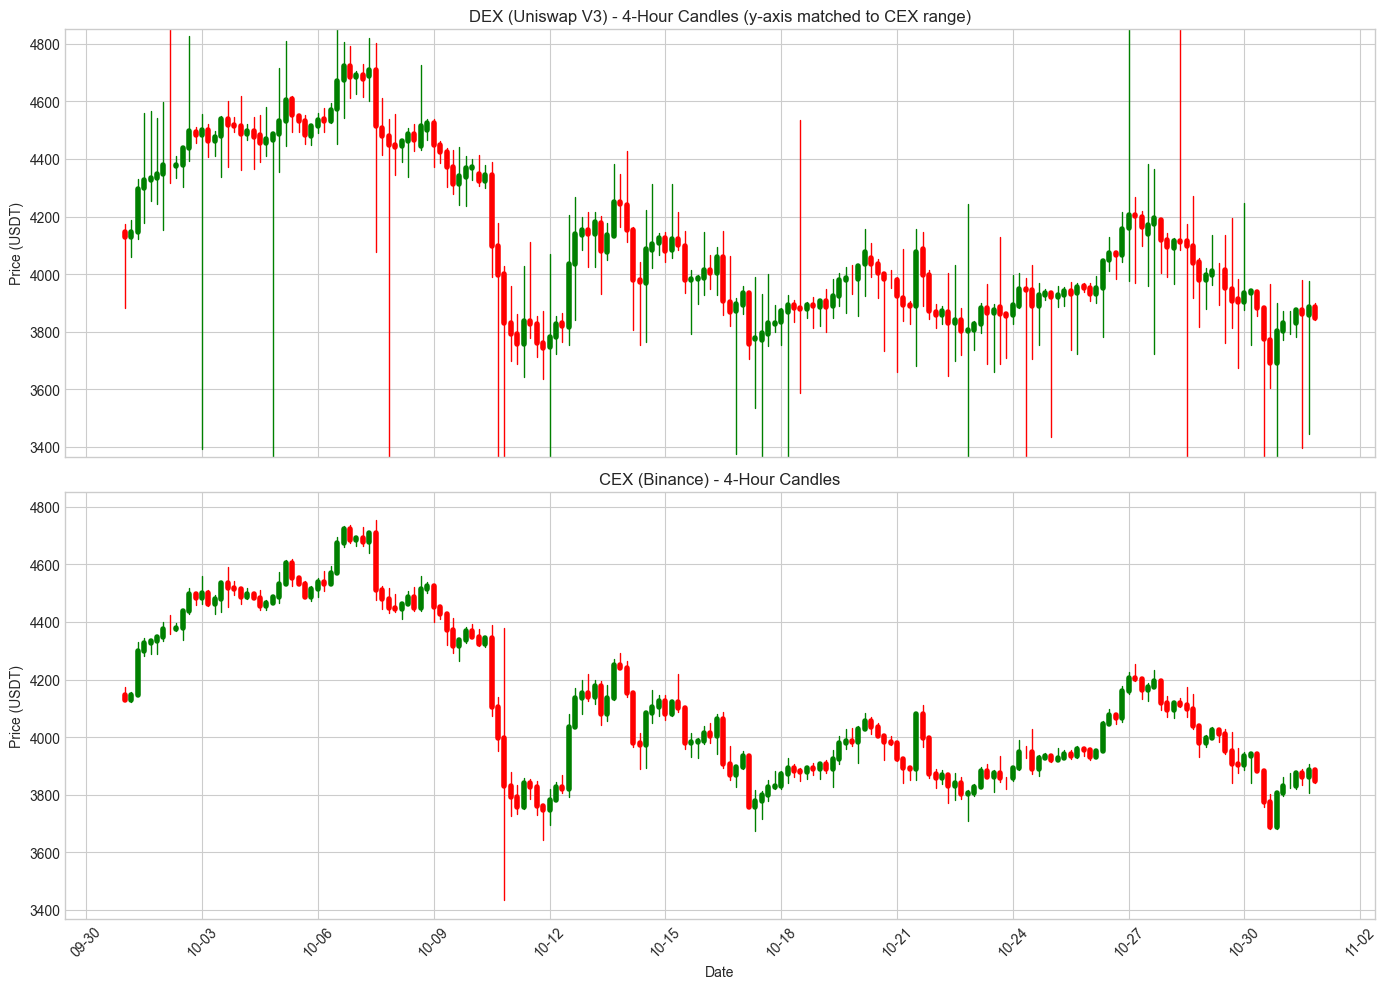

DEX candles with wicks clipped: 16 / 186


In [64]:
# Plot 3: Candlestick-style visualization (matched y-axis scaling)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Use CEX price range as the reference for both charts
y_min = candles_4h['low_cex'].min() * 0.98
y_max = candles_4h['high_cex'].max() * 1.02

# DEX candlesticks
ax1 = axes[0]
for idx, row in candles_4h.iterrows():
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    # High-low line (will be clipped if outside range)
    ax1.plot([idx, idx], [row['low_dex'], row['high_dex']], color=color, linewidth=1, clip_on=True)
    # Open-close box
    ax1.plot([idx, idx], [row['open_dex'], row['close_dex']], color=color, linewidth=4)

ax1.set_ylim(y_min, y_max)
ax1.set_ylabel('Price (USDT)')
ax1.set_title('DEX (Uniswap V3) - 4-Hour Candles (y-axis matched to CEX range)')

# CEX candlesticks
ax2 = axes[1]
for idx, row in candles_4h.iterrows():
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    # High-low line
    ax2.plot([idx, idx], [row['low_cex'], row['high_cex']], color=color, linewidth=1)
    # Open-close box
    ax2.plot([idx, idx], [row['open_cex'], row['close_cex']], color=color, linewidth=4)

ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USDT)')
ax2.set_title('CEX (Binance) - 4-Hour Candles')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show how many DEX candles have wicks outside the visible range
dex_outside = ((candles_4h['low_dex'] < y_min) | (candles_4h['high_dex'] > y_max)).sum()
print(f"DEX candles with wicks clipped: {dex_outside} / {len(candles_4h)}")

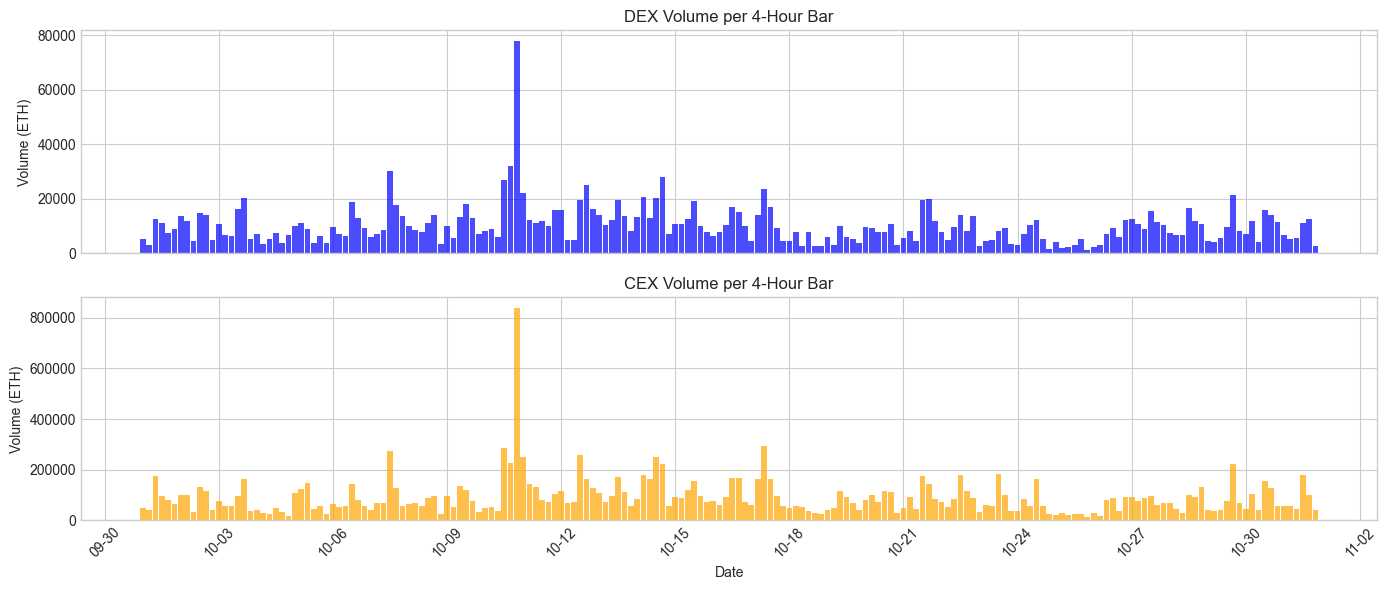

Volume ratio (CEX/DEX): 9.0x


In [65]:
# Plot 4: Volume comparison
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

axes[0].bar(candles_4h.index, candles_4h['volume_eth_dex'], width=0.15, alpha=0.7, color='blue')
axes[0].set_ylabel('Volume (ETH)')
axes[0].set_title('DEX Volume per 4-Hour Bar')

axes[1].bar(candles_4h.index, candles_4h['volume_eth_cex'], width=0.15, alpha=0.7, color='orange')
axes[1].set_ylabel('Volume (ETH)')
axes[1].set_title('CEX Volume per 4-Hour Bar')
axes[1].set_xlabel('Date')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Volume ratio (CEX/DEX): {candles_4h['volume_eth_cex'].sum() / candles_4h['volume_eth_dex'].sum():.1f}x")

In [66]:
# Save the aligned 4h candles for later analysis
candles_4h.to_parquet('candles_4h_dex_cex.parquet')
print("Saved: candles_4h_dex_cex.parquet")

Saved: candles_4h_dex_cex.parquet


## Section 5: 1-Minute Time Candles

In [67]:
# Build 1-minute DEX candles
dex_1m = dex.resample('1min').agg({
    'price_usdt_per_eth': ['first', 'max', 'min', 'last'],
    'abs_eth_volume': 'sum',
    'abs_usdt_volume': 'sum'
})

dex_1m.columns = ['open', 'high', 'low', 'close', 'volume_eth', 'volume_usdt']

# Compute VWAP
dex_1m_vwap = dex.resample('1min').apply(
    lambda x: np.average(x['price_usdt_per_eth'], weights=x['abs_eth_volume']) 
    if x['abs_eth_volume'].sum() > 0 else np.nan
)
dex_1m['vwap'] = dex_1m_vwap

# Count trades per candle
dex_1m['trade_count'] = dex.resample('1min').size()

# Drop empty candles
dex_1m = dex_1m.dropna()

print(f"DEX 1-min candles: {len(dex_1m):,} bars")
dex_1m.head(10)

DEX 1-min candles: 44,791 bars


,open,high,low,close,volume_eth,volume_usdt,vwap,trade_count
datetime,,,,,,,,
2025-10-01 00:00:00,4146.216013,4147.126351,4121.601882,4147.126351,33.961499,140820.312681,4146.469289,9
2025-10-01 00:01:00,4147.923374,4150.640850,4147.095522,4150.585348,100.647403,417572.153608,4148.861661,18
2025-10-01 00:02:00,4146.017234,4150.737063,4144.638764,4148.921216,38.191283,158383.377125,4147.108005,17
2025-10-01 00:03:00,4148.773226,4150.900528,4126.193186,4149.004308,12.151526,50434.950577,4150.503584,14
2025-10-01 00:04:00,4149.986853,4151.287354,4149.093380,4151.236725,14.898949,61847.573239,4151.136664,8
2025-10-01 00:05:00,4151.355219,4151.566610,4150.593852,4150.593852,3.224121,13384.950097,4151.504161,5
2025-10-01 00:06:00,4151.487208,4151.886312,4150.534358,4151.613603,9.686878,40216.300740,4151.626708,7
2025-10-01 00:07:00,4151.021195,4151.021195,4149.637540,4150.143334,5.277620,21904.034490,4150.362316,8
2025-10-01 00:08:00,4149.293330,4149.933842,4146.343645,4149.508153,7.276120,30177.965988,4147.535593,6


In [68]:
# Build 1-minute CEX candles
cex_1m = cex.resample('1min').agg({
    'price': ['first', 'max', 'min', 'last'],
    'quantity': 'sum',
    'trade_value': 'sum'
})

cex_1m.columns = ['open', 'high', 'low', 'close', 'volume_eth', 'volume_usdt']

# Compute VWAP
cex_1m['vwap'] = cex_1m['volume_usdt'] / cex_1m['volume_eth']

# Count trades per candle
cex_1m['trade_count'] = cex.resample('1min').size()

# Drop empty candles
cex_1m = cex_1m.dropna()

print(f"CEX 1-min candles: {len(cex_1m):,} bars")
cex_1m.head(10)

CEX 1-min candles: 44,640 bars


,open,high,low,close,volume_eth,volume_usdt,vwap,trade_count
datetime,,,,,,,,
2025-10-01 00:00:00,4145.15,4147.39,4144.65,4146.66,361.7609,1.500019e+06,4146.437461,932
2025-10-01 00:01:00,4146.67,4150.82,4146.67,4150.82,215.6351,8.948003e+05,4149.603921,1081
2025-10-01 00:02:00,4150.82,4150.82,4149.33,4150.53,98.7609,4.098714e+05,4150.138780,644
2025-10-01 00:03:00,4150.52,4151.38,4148.90,4148.90,212.8012,8.832200e+05,4150.446504,783
2025-10-01 00:04:00,4148.89,4151.41,4148.40,4151.41,149.4735,6.202159e+05,4149.336812,503
2025-10-01 00:05:00,4151.41,4151.88,4151.00,4151.00,122.4352,5.083166e+05,4151.719326,279
2025-10-01 00:06:00,4150.99,4152.37,4149.77,4152.23,290.1769,1.204722e+06,4151.679866,785
2025-10-01 00:07:00,4152.24,4152.24,4149.21,4149.22,90.4553,3.754069e+05,4150.192505,428
2025-10-01 00:08:00,4149.22,4149.57,4148.34,4149.26,79.5584,3.300851e+05,4148.966030,449


In [69]:
# Merge 1-minute candles
candles_1m = pd.merge(
    dex_1m[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    cex_1m[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex'),
    how='inner'
)

print(f"Aligned 1-min candles: {len(candles_1m):,} bars")
print(f"Time range: {candles_1m.index.min()} to {candles_1m.index.max()}")

# Compare to 4h bars
print(f"\nComparison: 4h bars = {len(candles_4h)}, 1m bars = {len(candles_1m):,} ({len(candles_1m)/len(candles_4h):.0f}x more)")
candles_1m.head(10)

Aligned 1-min candles: 44,611 bars
Time range: 2025-10-01 00:00:00 to 2025-10-31 23:59:00

Comparison: 4h bars = 186, 1m bars = 44,611 (240x more)


,open_dex,high_dex,low_dex,close_dex,vwap_dex,volume_eth_dex,trade_count_dex,open_cex,high_cex,low_cex,close_cex,vwap_cex,volume_eth_cex,trade_count_cex
datetime,,,,,,,,,,,,,,
2025-10-01 00:00:00,4146.216013,4147.126351,4121.601882,4147.126351,4146.469289,33.961499,9,4145.15,4147.39,4144.65,4146.66,4146.437461,361.7609,932
2025-10-01 00:01:00,4147.923374,4150.640850,4147.095522,4150.585348,4148.861661,100.647403,18,4146.67,4150.82,4146.67,4150.82,4149.603921,215.6351,1081
2025-10-01 00:02:00,4146.017234,4150.737063,4144.638764,4148.921216,4147.108005,38.191283,17,4150.82,4150.82,4149.33,4150.53,4150.138780,98.7609,644
2025-10-01 00:03:00,4148.773226,4150.900528,4126.193186,4149.004308,4150.503584,12.151526,14,4150.52,4151.38,4148.90,4148.90,4150.446504,212.8012,783
2025-10-01 00:04:00,4149.986853,4151.287354,4149.093380,4151.236725,4151.136664,14.898949,8,4148.89,4151.41,4148.40,4151.41,4149.336812,149.4735,503
2025-10-01 00:05:00,4151.355219,4151.566610,4150.593852,4150.593852,4151.504161,3.224121,5,4151.41,4151.88,4151.00,4151.00,4151.719326,122.4352,279
2025-10-01 00:06:00,4151.487208,4151.886312,4150.534358,4151.613603,4151.626708,9.686878,7,4150.99,4152.37,4149.77,4152.23,4151.679866,290.1769,785
2025-10-01 00:07:00,4151.021195,4151.021195,4149.637540,4150.143334,4150.362316,5.277620,8,4152.24,4152.24,4149.21,4149.22,4150.192505,90.4553,428
2025-10-01 00:08:00,4149.293330,4149.933842,4146.343645,4149.508153,4147.535593,7.276120,6,4149.22,4149.57,4148.34,4149.26,4148.966030,79.5584,449


In [70]:
# Quick stats for 1-minute candles
print("=== 1-Minute Candle Stats ===")
print(f"DEX avg trades/candle: {candles_1m['trade_count_dex'].mean():.1f}")
print(f"CEX avg trades/candle: {candles_1m['trade_count_cex'].mean():.0f}")
print(f"DEX avg volume/candle: {candles_1m['volume_eth_dex'].mean():.2f} ETH")
print(f"CEX avg volume/candle: {candles_1m['volume_eth_cex'].mean():.1f} ETH")
print()

# Coverage: what % of 1-minute slots have DEX activity?
total_minutes = (candles_1m.index.max() - candles_1m.index.min()).total_seconds() / 60
print(f"Time span: {total_minutes:,.0f} minutes")
print(f"Minutes with DEX+CEX activity: {len(candles_1m):,} ({100*len(candles_1m)/total_minutes:.1f}%)")

=== 1-Minute Candle Stats ===
DEX avg trades/candle: 13.7
CEX avg trades/candle: 1125
DEX avg volume/candle: 42.96 ETH
CEX avg volume/candle: 385.8 ETH

Time span: 44,639 minutes
Minutes with DEX+CEX activity: 44,611 (99.9%)


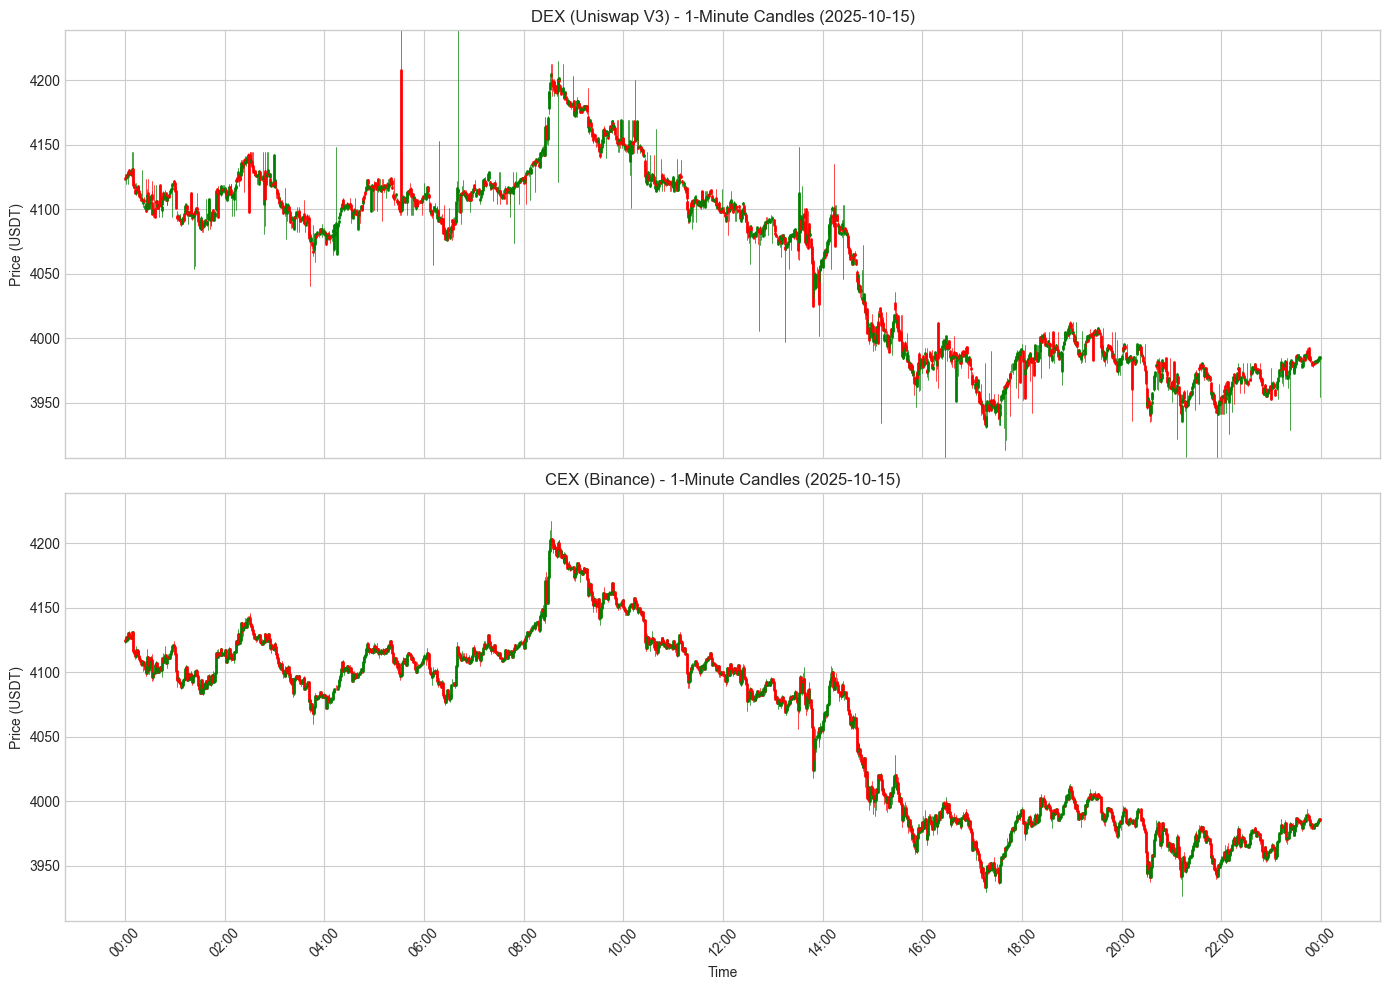

Showing 1440 candles for 2025-10-15


In [71]:
# Plot: 1-minute candlesticks for a single day (too many bars to show full month)
sample_day = '2025-10-15'
candles_1m_day = candles_1m.loc[sample_day]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Use CEX range for y-axis
y_min = candles_1m_day['low_cex'].min() * 0.995
y_max = candles_1m_day['high_cex'].max() * 1.005

# DEX candlesticks
ax1 = axes[0]
for idx, row in candles_1m_day.iterrows():
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    ax1.plot([idx, idx], [row['low_dex'], row['high_dex']], color=color, linewidth=0.5)
    ax1.plot([idx, idx], [row['open_dex'], row['close_dex']], color=color, linewidth=2)

ax1.set_ylim(y_min, y_max)
ax1.set_ylabel('Price (USDT)')
ax1.set_title(f'DEX (Uniswap V3) - 1-Minute Candles ({sample_day})')

# CEX candlesticks
ax2 = axes[1]
for idx, row in candles_1m_day.iterrows():
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    ax2.plot([idx, idx], [row['low_cex'], row['high_cex']], color=color, linewidth=0.5)
    ax2.plot([idx, idx], [row['open_cex'], row['close_cex']], color=color, linewidth=2)

ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Time')
ax2.set_ylabel('Price (USDT)')
ax2.set_title(f'CEX (Binance) - 1-Minute Candles ({sample_day})')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Showing {len(candles_1m_day)} candles for {sample_day}")

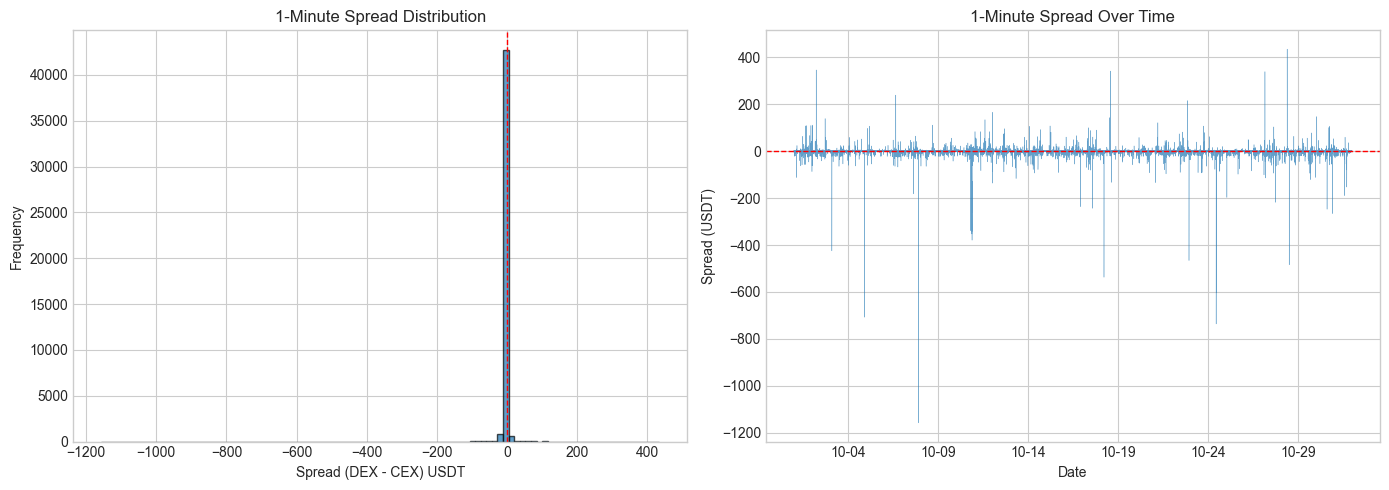

Spread stats: mean=-0.83, std=14.11, min=-1157.31, max=434.01


In [74]:
# Plot: Spread distribution (1-minute)
spread_1m = candles_1m['vwap_dex'] - candles_1m['vwap_cex']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of spreads
axes[0].hist(spread_1m, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Spread (DEX - CEX) USDT')
axes[0].set_ylabel('Frequency')
axes[0].set_title('1-Minute Spread Distribution')

# Spread over time
axes[1].plot(candles_1m.index, spread_1m, linewidth=0.3, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Spread (USDT)')
axes[1].set_title('1-Minute Spread Over Time')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=5))

plt.tight_layout()
plt.show()

print(f"Spread stats: mean={spread_1m.mean():.2f}, std={spread_1m.std():.2f}, min={spread_1m.min():.2f}, max={spread_1m.max():.2f}")

In [75]:
# Save 1-minute candles
candles_1m.to_parquet('candles_1m_dex_cex.parquet')
print("Saved: candles_1m_dex_cex.parquet")

Saved: candles_1m_dex_cex.parquet


## Section 6: Volume Bars (DEX-anchored)

In [84]:
# Determine volume bar size
# Target similar bar count to 4h candles for comparability

total_dex_volume = dex['abs_eth_volume'].sum()
target_bar_count = len(candles_4h)  # Match 4h bar count (~186)

vol_bar_size = total_dex_volume / target_bar_count

print(f"Total DEX volume: {total_dex_volume:,.0f} ETH")
print(f"Target bar count: {target_bar_count}")
print(f"Volume per bar: {vol_bar_size:,.0f} ETH")

Total DEX volume: 1,921,183 ETH
Target bar count: 186
Volume per bar: 10,329 ETH


In [85]:
# Build DEX volume bars
dex_for_vol = dex.copy()
dex_for_vol['cumulative_volume'] = dex_for_vol['abs_eth_volume'].cumsum()
dex_for_vol['bar'] = (dex_for_vol['cumulative_volume'] // vol_bar_size).astype(int)

# Aggregate by bar
dex_vol = dex_for_vol.groupby('bar').agg(
    open=('price_usdt_per_eth', 'first'),
    high=('price_usdt_per_eth', 'max'),
    low=('price_usdt_per_eth', 'min'),
    close=('price_usdt_per_eth', 'last'),
    volume_eth=('abs_eth_volume', 'sum'),
    volume_usdt=('abs_usdt_volume', 'sum'),
    trade_count=('price_usdt_per_eth', 'count'),
    start_time=('timestamp', lambda x: pd.to_datetime(x.iloc[0], unit='s')),
    end_time=('timestamp', lambda x: pd.to_datetime(x.iloc[-1], unit='s'))
)

# Compute VWAP per bar
vwap_per_bar = dex_for_vol.groupby('bar').apply(
    lambda x: np.average(x['price_usdt_per_eth'], weights=x['abs_eth_volume'])
)
dex_vol['vwap'] = vwap_per_bar

# Compute bar duration
dex_vol['duration'] = dex_vol['end_time'] - dex_vol['start_time']

print(f"DEX volume bars: {len(dex_vol)} bars")
print(f"Avg volume per bar: {dex_vol['volume_eth'].mean():,.0f} ETH")
print(f"Avg duration per bar: {dex_vol['duration'].mean()}")
dex_vol.head(10)

DEX volume bars: 186 bars
Avg volume per bar: 10,329 ETH
Avg duration per bar: 0 days 04:00:54.838709677


/var/folders/gc/yd_l4qvx2g745jhrhw_n5b4w0000gn/T/ipykernel_86989/1516065949.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwap_per_bar = dex_for_vol.groupby('bar').apply(


,open,high,low,close,volume_eth,volume_usdt,trade_count,start_time,end_time,vwap,duration
bar,,,,,,,,,,,
0,4146.216013,4206.591746,3882.495109,4206.467324,10200.783993,4.223351e+07,6070,2025-10-01 00:00:11,2025-10-01 08:35:47,4140.221593,0 days 08:35:36
1,4201.338510,4329.094391,4147.951111,4294.129948,10454.572291,4.469230e+07,3226,2025-10-01 08:35:47,2025-10-01 11:54:11,4274.904891,0 days 03:18:24
2,4294.952199,4558.637436,4176.248098,4209.372559,10064.113417,4.342688e+07,2588,2025-10-01 11:54:11,2025-10-01 15:48:47,4315.022577,0 days 03:54:36
3,4272.610279,4565.837404,4244.320009,4323.737596,10595.276523,4.579801e+07,3459,2025-10-01 15:48:47,2025-10-01 21:17:35,4322.493598,0 days 05:28:48
4,4324.202340,4541.360054,4153.151773,4353.796650,10295.957125,4.470167e+07,2584,2025-10-01 21:17:35,2025-10-02 00:27:59,4341.671686,0 days 03:10:24
5,4288.094510,4596.281824,4225.465023,4375.471114,10361.927380,4.541451e+07,2924,2025-10-02 00:27:59,2025-10-02 03:54:47,4382.824380,0 days 03:26:48
6,4377.594481,7308.273168,4324.059730,4404.083977,10328.513779,4.598951e+07,2433,2025-10-02 03:54:47,2025-10-02 07:07:11,4452.674920,0 days 03:12:24
7,4403.098294,4422.063924,4304.066844,4408.170629,10303.502644,4.517285e+07,4085,2025-10-02 07:07:11,2025-10-02 13:47:35,4384.222733,0 days 06:40:24
8,4413.164194,4434.333952,4317.848202,4431.228247,10353.252339,4.545228e+07,1726,2025-10-02 13:47:47,2025-10-02 15:54:59,4390.145262,0 days 02:07:12


In [86]:
# Build CEX bars matched to DEX volume bar time windows
cex_vol_bars = []

for bar_id, row in dex_vol.iterrows():
    start = row['start_time']
    end = row['end_time']
    
    # Get CEX trades in this time window
    mask = (cex.index >= start) & (cex.index <= end)
    cex_window = cex.loc[mask]
    
    if len(cex_window) > 0:
        cex_vol_bars.append({
            'bar': bar_id,
            'open': cex_window['price'].iloc[0],
            'high': cex_window['price'].max(),
            'low': cex_window['price'].min(),
            'close': cex_window['price'].iloc[-1],
            'volume_eth': cex_window['quantity'].sum(),
            'volume_usdt': cex_window['trade_value'].sum(),
            'trade_count': len(cex_window),
            'vwap': cex_window['trade_value'].sum() / cex_window['quantity'].sum()
        })
    else:
        # No CEX trades in this window (rare edge case)
        cex_vol_bars.append({
            'bar': bar_id,
            'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan,
            'volume_eth': 0, 'volume_usdt': 0, 'trade_count': 0, 'vwap': np.nan
        })

cex_vol = pd.DataFrame(cex_vol_bars).set_index('bar')
print(f"CEX matched bars: {len(cex_vol)} bars")
cex_vol.head(10)

CEX matched bars: 186 bars


,open,high,low,close,volume_eth,volume_usdt,trade_count,vwap
bar,,,,,,,,
0,4146.37,4205.88,4123.08,4205.87,110656.0757,4.592274e+08,303043,4150.042477
1,4205.64,4329.00,4203.12,4296.26,152461.9207,6.531259e+08,279315,4283.862447
2,4296.26,4344.00,4280.00,4329.36,96930.4142,4.179731e+08,273944,4312.094024
3,4329.35,4340.00,4288.64,4324.00,103857.9685,4.491594e+08,209788,4324.746404
4,4324.00,4380.87,4287.50,4353.78,70818.4576,3.071939e+08,161363,4337.766254
5,4353.77,4399.11,4332.73,4373.94,71821.5071,3.143485e+08,166087,4376.802325
6,4373.94,4423.35,4358.26,4402.92,87096.7074,3.821136e+08,128086,4387.233838
7,4402.93,4417.80,4369.32,4409.45,86268.8612,3.786943e+08,208476,4389.698845
8,4417.44,4436.90,4335.74,4431.23,88861.5791,3.906070e+08,198876,4395.679553


In [87]:
# Merge DEX and CEX volume bars
candles_vol = pd.merge(
    dex_vol[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count', 'start_time', 'end_time', 'duration']],
    cex_vol[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex'),
    how='inner'
)

# Drop any bars with missing CEX data
candles_vol = candles_vol.dropna()

print(f"Aligned volume bars: {len(candles_vol)} bars")
print()
print("=== Volume Bar Stats ===")
print(f"DEX avg volume/bar: {candles_vol['volume_eth_dex'].mean():,.0f} ETH")
print(f"CEX avg volume/bar: {candles_vol['volume_eth_cex'].mean():,.0f} ETH")
print(f"DEX avg trades/bar: {candles_vol['trade_count_dex'].mean():,.0f}")
print(f"CEX avg trades/bar: {candles_vol['trade_count_cex'].mean():,.0f}")
print(f"Avg bar duration: {candles_vol['duration'].mean()}")
print(f"Min bar duration: {candles_vol['duration'].min()}")
print(f"Max bar duration: {candles_vol['duration'].max()}")

candles_vol.head(10)

Aligned volume bars: 186 bars

=== Volume Bar Stats ===
DEX avg volume/bar: 10,329 ETH
CEX avg volume/bar: 92,488 ETH
DEX avg trades/bar: 3,285
CEX avg trades/bar: 269,881
Avg bar duration: 0 days 04:00:54.838709677
Min bar duration: 0 days 00:05:48
Max bar duration: 0 days 15:27:24


,open_dex,high_dex,low_dex,close_dex,vwap_dex,volume_eth_dex,trade_count_dex,start_time,end_time,duration,open_cex,high_cex,low_cex,close_cex,vwap_cex,volume_eth_cex,trade_count_cex
bar,,,,,,,,,,,,,,,,,
0,4146.216013,4206.591746,3882.495109,4206.467324,4140.221593,10200.783993,6070,2025-10-01 00:00:11,2025-10-01 08:35:47,0 days 08:35:36,4146.37,4205.88,4123.08,4205.87,4150.042477,110656.0757,303043
1,4201.338510,4329.094391,4147.951111,4294.129948,4274.904891,10454.572291,3226,2025-10-01 08:35:47,2025-10-01 11:54:11,0 days 03:18:24,4205.64,4329.00,4203.12,4296.26,4283.862447,152461.9207,279315
2,4294.952199,4558.637436,4176.248098,4209.372559,4315.022577,10064.113417,2588,2025-10-01 11:54:11,2025-10-01 15:48:47,0 days 03:54:36,4296.26,4344.00,4280.00,4329.36,4312.094024,96930.4142,273944
3,4272.610279,4565.837404,4244.320009,4323.737596,4322.493598,10595.276523,3459,2025-10-01 15:48:47,2025-10-01 21:17:35,0 days 05:28:48,4329.35,4340.00,4288.64,4324.00,4324.746404,103857.9685,209788
4,4324.202340,4541.360054,4153.151773,4353.796650,4341.671686,10295.957125,2584,2025-10-01 21:17:35,2025-10-02 00:27:59,0 days 03:10:24,4324.00,4380.87,4287.50,4353.78,4337.766254,70818.4576,161363
5,4288.094510,4596.281824,4225.465023,4375.471114,4382.824380,10361.927380,2924,2025-10-02 00:27:59,2025-10-02 03:54:47,0 days 03:26:48,4353.77,4399.11,4332.73,4373.94,4376.802325,71821.5071,166087
6,4377.594481,7308.273168,4324.059730,4404.083977,4452.674920,10328.513779,2433,2025-10-02 03:54:47,2025-10-02 07:07:11,0 days 03:12:24,4373.94,4423.35,4358.26,4402.92,4387.233838,87096.7074,128086
7,4403.098294,4422.063924,4304.066844,4408.170629,4384.222733,10303.502644,4085,2025-10-02 07:07:11,2025-10-02 13:47:35,0 days 06:40:24,4402.93,4417.80,4369.32,4409.45,4389.698845,86268.8612,208476
8,4413.164194,4434.333952,4317.848202,4431.228247,4390.145262,10353.252339,1726,2025-10-02 13:47:47,2025-10-02 15:54:59,0 days 02:07:12,4417.44,4436.90,4335.74,4431.23,4395.679553,88861.5791,198876


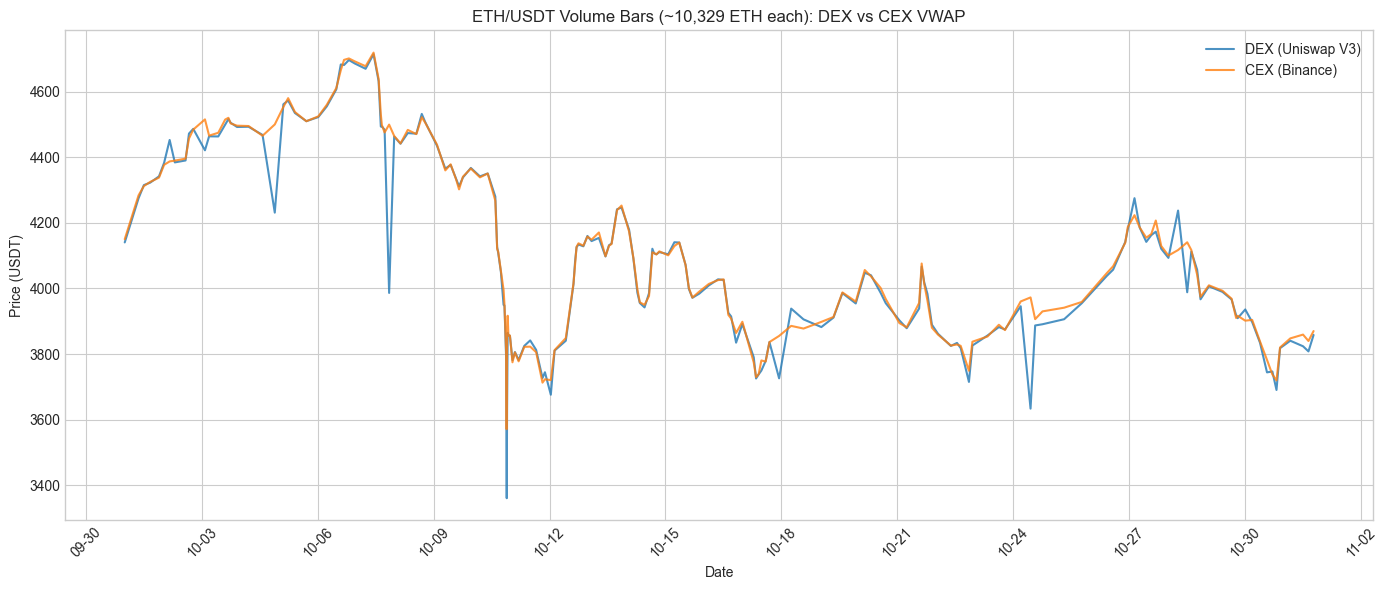

In [88]:
# Plot: VWAP comparison for volume bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(candles_vol['start_time'], candles_vol['vwap_dex'], label='DEX (Uniswap V3)', alpha=0.8)
ax.plot(candles_vol['start_time'], candles_vol['vwap_cex'], label='CEX (Binance)', alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Price (USDT)')
ax.set_title(f'ETH/USDT Volume Bars (~{vol_bar_size:,.0f} ETH each): DEX vs CEX VWAP')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

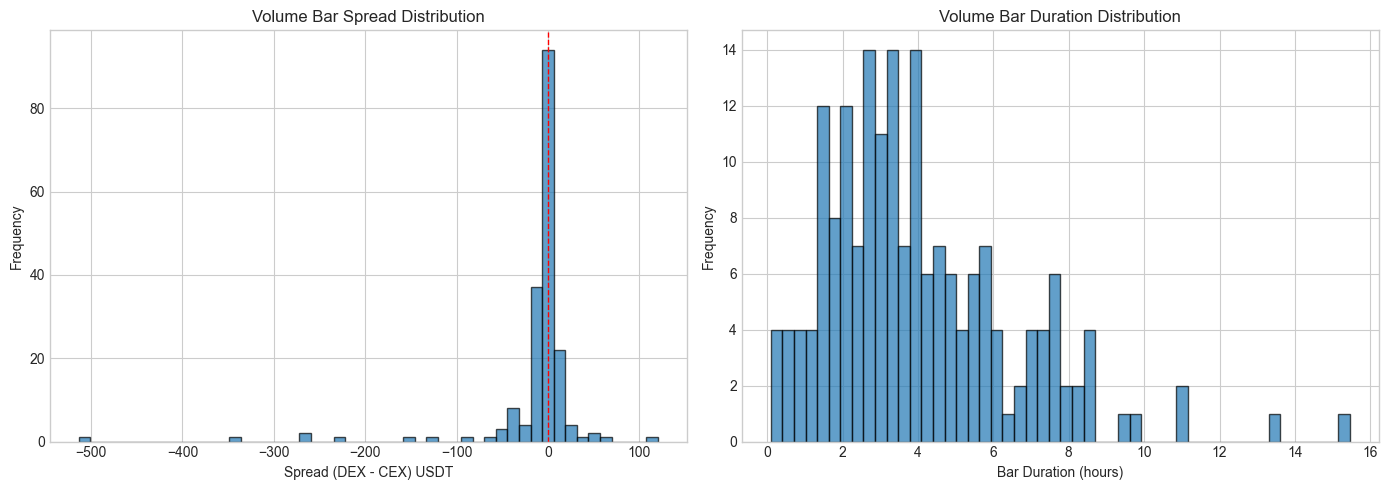

Spread stats: mean=-12.94, std=59.45
Duration stats: mean=4.0h, min=0.10h, max=15.5h


In [89]:
# Plot: Spread and bar duration distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread distribution
spread_vol = candles_vol['vwap_dex'] - candles_vol['vwap_cex']
axes[0].hist(spread_vol, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1)
axes[0].set_xlabel('Spread (DEX - CEX) USDT')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Volume Bar Spread Distribution')

# Bar duration distribution
duration_hours = candles_vol['duration'].dt.total_seconds() / 3600
axes[1].hist(duration_hours, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Bar Duration (hours)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Volume Bar Duration Distribution')

plt.tight_layout()
plt.show()

print(f"Spread stats: mean={spread_vol.mean():.2f}, std={spread_vol.std():.2f}")
print(f"Duration stats: mean={duration_hours.mean():.1f}h, min={duration_hours.min():.2f}h, max={duration_hours.max():.1f}h")

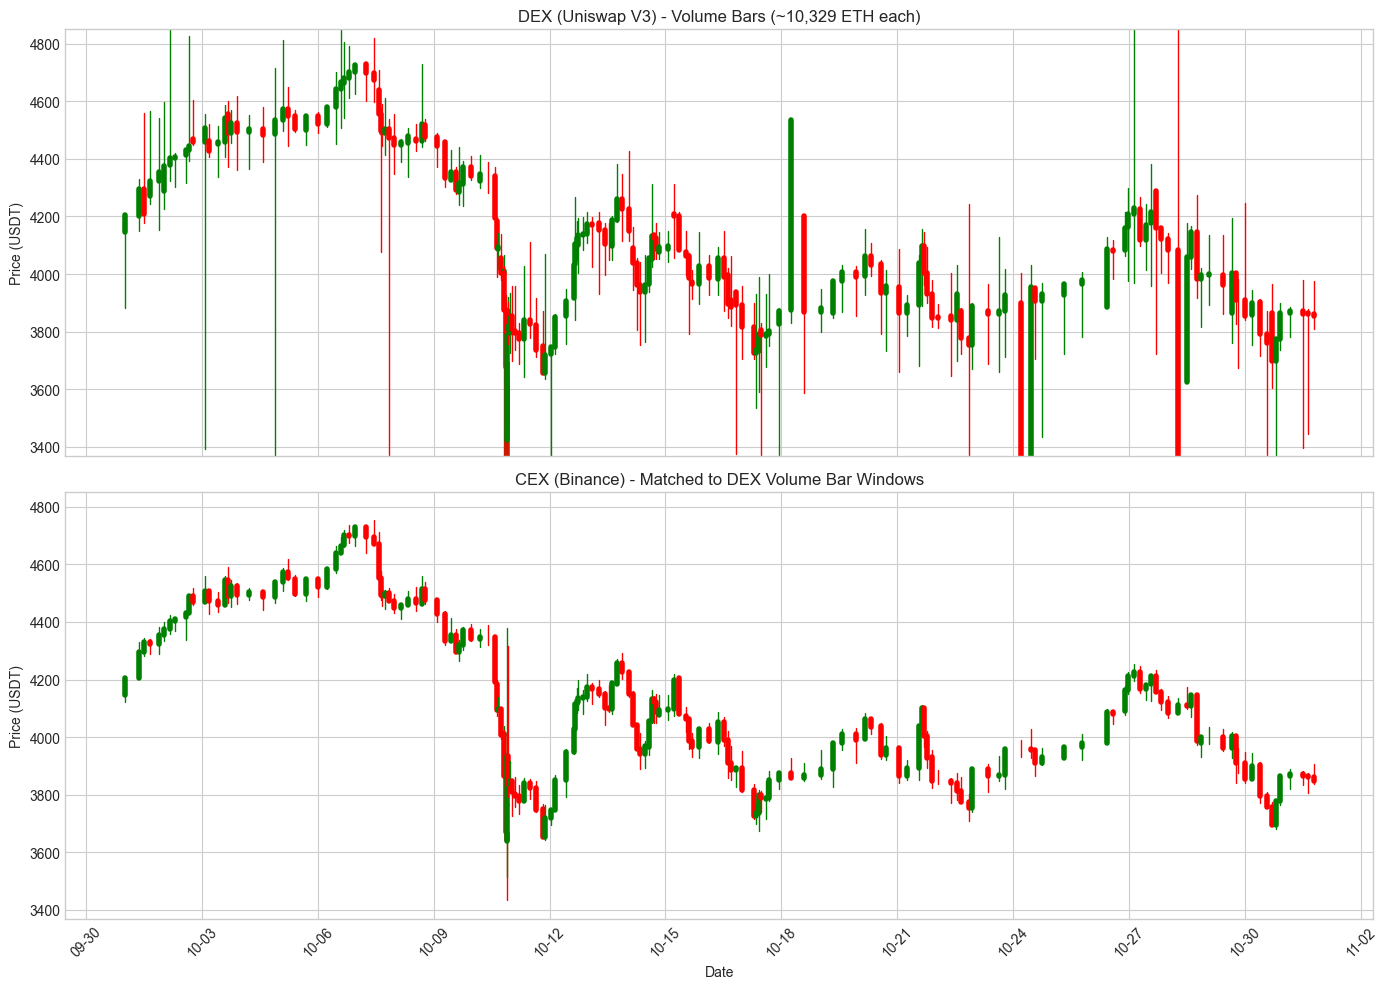

In [90]:
# Plot: Candlestick comparison for volume bars
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Use CEX range for y-axis
y_min = candles_vol['low_cex'].min() * 0.98
y_max = candles_vol['high_cex'].max() * 1.02

# DEX candlesticks
ax1 = axes[0]
for _, row in candles_vol.iterrows():
    x = row['start_time']
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    ax1.plot([x, x], [row['low_dex'], row['high_dex']], color=color, linewidth=1)
    ax1.plot([x, x], [row['open_dex'], row['close_dex']], color=color, linewidth=4)

ax1.set_ylim(y_min, y_max)
ax1.set_ylabel('Price (USDT)')
ax1.set_title(f'DEX (Uniswap V3) - Volume Bars (~{vol_bar_size:,.0f} ETH each)')

# CEX candlesticks
ax2 = axes[1]
for _, row in candles_vol.iterrows():
    x = row['start_time']
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    ax2.plot([x, x], [row['low_cex'], row['high_cex']], color=color, linewidth=1)
    ax2.plot([x, x], [row['open_cex'], row['close_cex']], color=color, linewidth=4)

ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USDT)')
ax2.set_title('CEX (Binance) - Matched to DEX Volume Bar Windows')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save volume bars
candles_vol.to_parquet('candles_vol_dex_cex.parquet')
print("Saved: candles_vol_dex_cex.parquet")

## Section 7: Fine Volume Bars (1,000 ETH per bar)

In [91]:
# Build DEX volume bars at 1,000 ETH per bar
vol_bar_size_fine = 1000  # ETH per bar

dex_for_vol_fine = dex.copy()
dex_for_vol_fine['cumulative_volume'] = dex_for_vol_fine['abs_eth_volume'].cumsum()
dex_for_vol_fine['bar'] = (dex_for_vol_fine['cumulative_volume'] // vol_bar_size_fine).astype(int)

# Aggregate by bar
dex_vol_fine = dex_for_vol_fine.groupby('bar').agg(
    open=('price_usdt_per_eth', 'first'),
    high=('price_usdt_per_eth', 'max'),
    low=('price_usdt_per_eth', 'min'),
    close=('price_usdt_per_eth', 'last'),
    volume_eth=('abs_eth_volume', 'sum'),
    volume_usdt=('abs_usdt_volume', 'sum'),
    trade_count=('price_usdt_per_eth', 'count'),
    start_time=('timestamp', lambda x: pd.to_datetime(x.iloc[0], unit='s')),
    end_time=('timestamp', lambda x: pd.to_datetime(x.iloc[-1], unit='s'))
)

# Compute VWAP per bar
vwap_fine = dex_for_vol_fine.groupby('bar').apply(
    lambda x: np.average(x['price_usdt_per_eth'], weights=x['abs_eth_volume'])
)
dex_vol_fine['vwap'] = vwap_fine
dex_vol_fine['duration'] = dex_vol_fine['end_time'] - dex_vol_fine['start_time']

print(f"DEX fine volume bars: {len(dex_vol_fine):,} bars")
print(f"Avg duration per bar: {dex_vol_fine['duration'].mean()}")

DEX fine volume bars: 1,910 bars
Avg duration per bar: 0 days 00:23:24.552879581


/var/folders/gc/yd_l4qvx2g745jhrhw_n5b4w0000gn/T/ipykernel_86989/144052600.py:22: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vwap_fine = dex_for_vol_fine.groupby('bar').apply(


In [92]:
# Build CEX bars matched to fine DEX volume bar windows
# Note: This may take a few minutes due to ~1,900 bars

cex_vol_fine_bars = []

for bar_id, row in dex_vol_fine.iterrows():
    start = row['start_time']
    end = row['end_time']
    
    mask = (cex.index >= start) & (cex.index <= end)
    cex_window = cex.loc[mask]
    
    if len(cex_window) > 0:
        cex_vol_fine_bars.append({
            'bar': bar_id,
            'open': cex_window['price'].iloc[0],
            'high': cex_window['price'].max(),
            'low': cex_window['price'].min(),
            'close': cex_window['price'].iloc[-1],
            'volume_eth': cex_window['quantity'].sum(),
            'volume_usdt': cex_window['trade_value'].sum(),
            'trade_count': len(cex_window),
            'vwap': cex_window['trade_value'].sum() / cex_window['quantity'].sum()
        })
    else:
        cex_vol_fine_bars.append({
            'bar': bar_id,
            'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan,
            'volume_eth': 0, 'volume_usdt': 0, 'trade_count': 0, 'vwap': np.nan
        })

cex_vol_fine = pd.DataFrame(cex_vol_fine_bars).set_index('bar')
print(f"CEX matched bars: {len(cex_vol_fine):,} bars")

CEX matched bars: 1,910 bars


In [93]:
# Merge fine volume bars
candles_vol_fine = pd.merge(
    dex_vol_fine[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count', 'start_time', 'end_time', 'duration']],
    cex_vol_fine[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex'),
    how='inner'
).dropna()

print(f"Aligned fine volume bars: {len(candles_vol_fine):,} bars")
print()
print("=== Fine Volume Bar Stats (1,000 ETH) ===")
print(f"DEX avg trades/bar: {candles_vol_fine['trade_count_dex'].mean():.0f}")
print(f"CEX avg trades/bar: {candles_vol_fine['trade_count_cex'].mean():,.0f}")
print(f"Avg bar duration: {candles_vol_fine['duration'].mean()}")
print(f"Min/Max duration: {candles_vol_fine['duration'].min()} / {candles_vol_fine['duration'].max()}")

Aligned fine volume bars: 1,878 bars

=== Fine Volume Bar Stats (1,000 ETH) ===
DEX avg trades/bar: 325
CEX avg trades/bar: 26,560
Avg bar duration: 0 days 00:23:43.124600638
Min/Max duration: 0 days 00:00:12 / 0 days 02:59:00


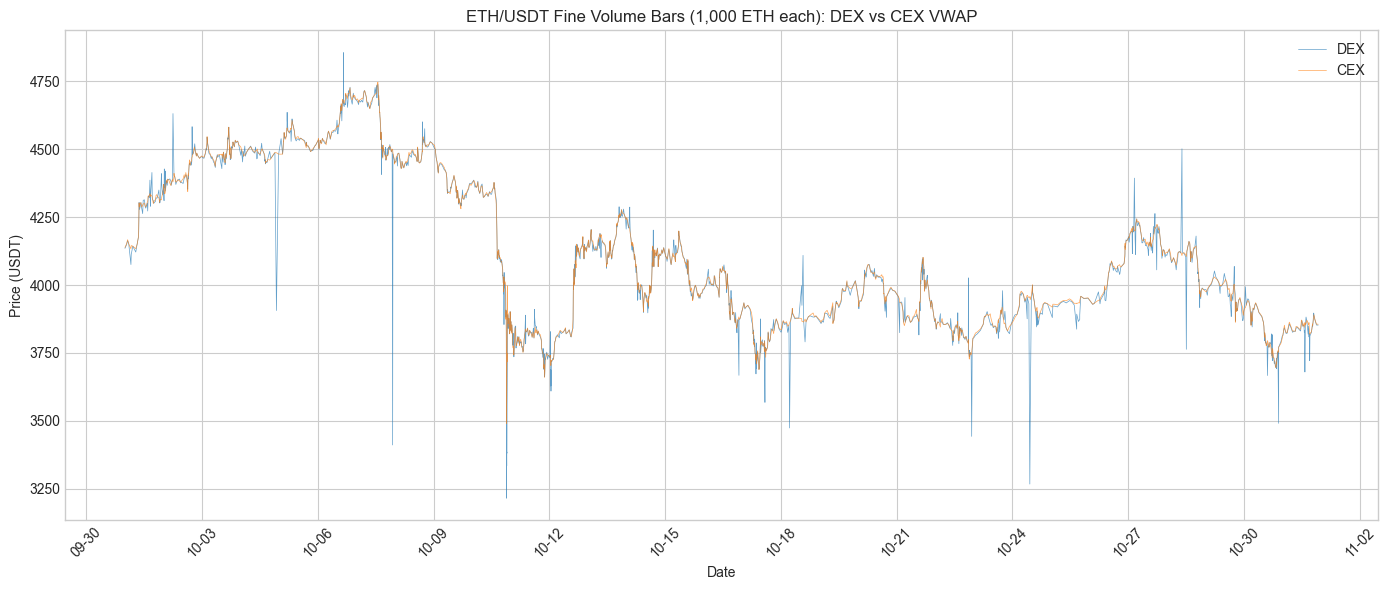

In [94]:
# Plot: VWAP comparison for fine volume bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(candles_vol_fine['start_time'], candles_vol_fine['vwap_dex'], label='DEX', alpha=0.7, linewidth=0.5)
ax.plot(candles_vol_fine['start_time'], candles_vol_fine['vwap_cex'], label='CEX', alpha=0.7, linewidth=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Price (USDT)')
ax.set_title('ETH/USDT Fine Volume Bars (1,000 ETH each): DEX vs CEX VWAP')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

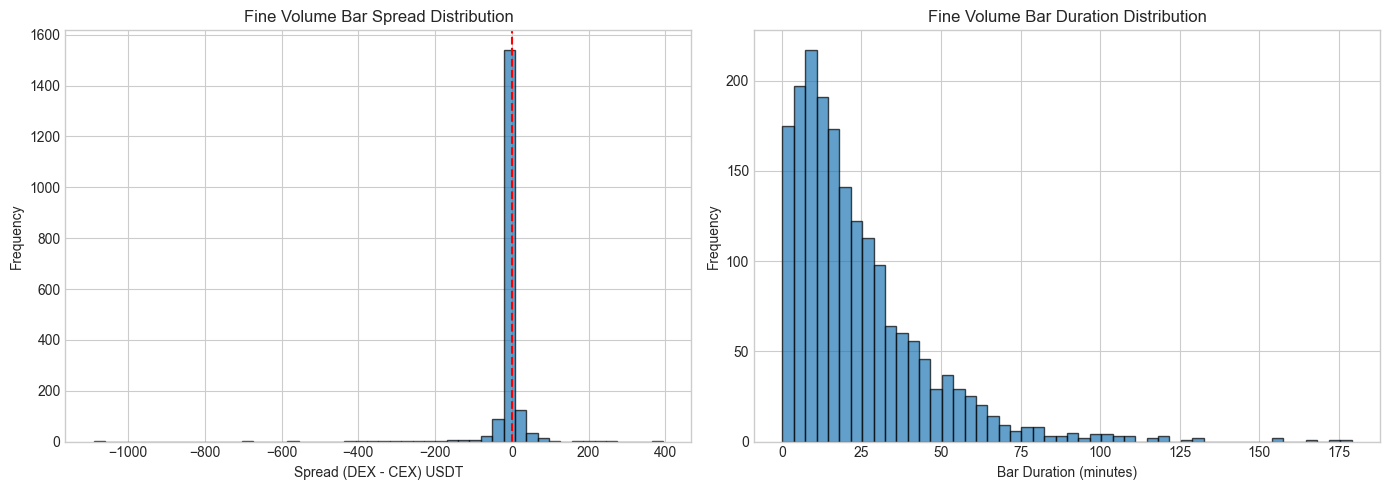

Spread stats: mean=-7.21, std=53.21
Duration stats: mean=23.7min, min=0.2min, max=179min


In [95]:
# Plot: Spread and duration for fine volume bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

spread_vol_fine = candles_vol_fine['vwap_dex'] - candles_vol_fine['vwap_cex']
axes[0].hist(spread_vol_fine, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('Spread (DEX - CEX) USDT')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Fine Volume Bar Spread Distribution')

duration_mins = candles_vol_fine['duration'].dt.total_seconds() / 60
axes[1].hist(duration_mins, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Bar Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Fine Volume Bar Duration Distribution')

plt.tight_layout()
plt.show()

print(f"Spread stats: mean={spread_vol_fine.mean():.2f}, std={spread_vol_fine.std():.2f}")
print(f"Duration stats: mean={duration_mins.mean():.1f}min, min={duration_mins.min():.1f}min, max={duration_mins.max():.0f}min")

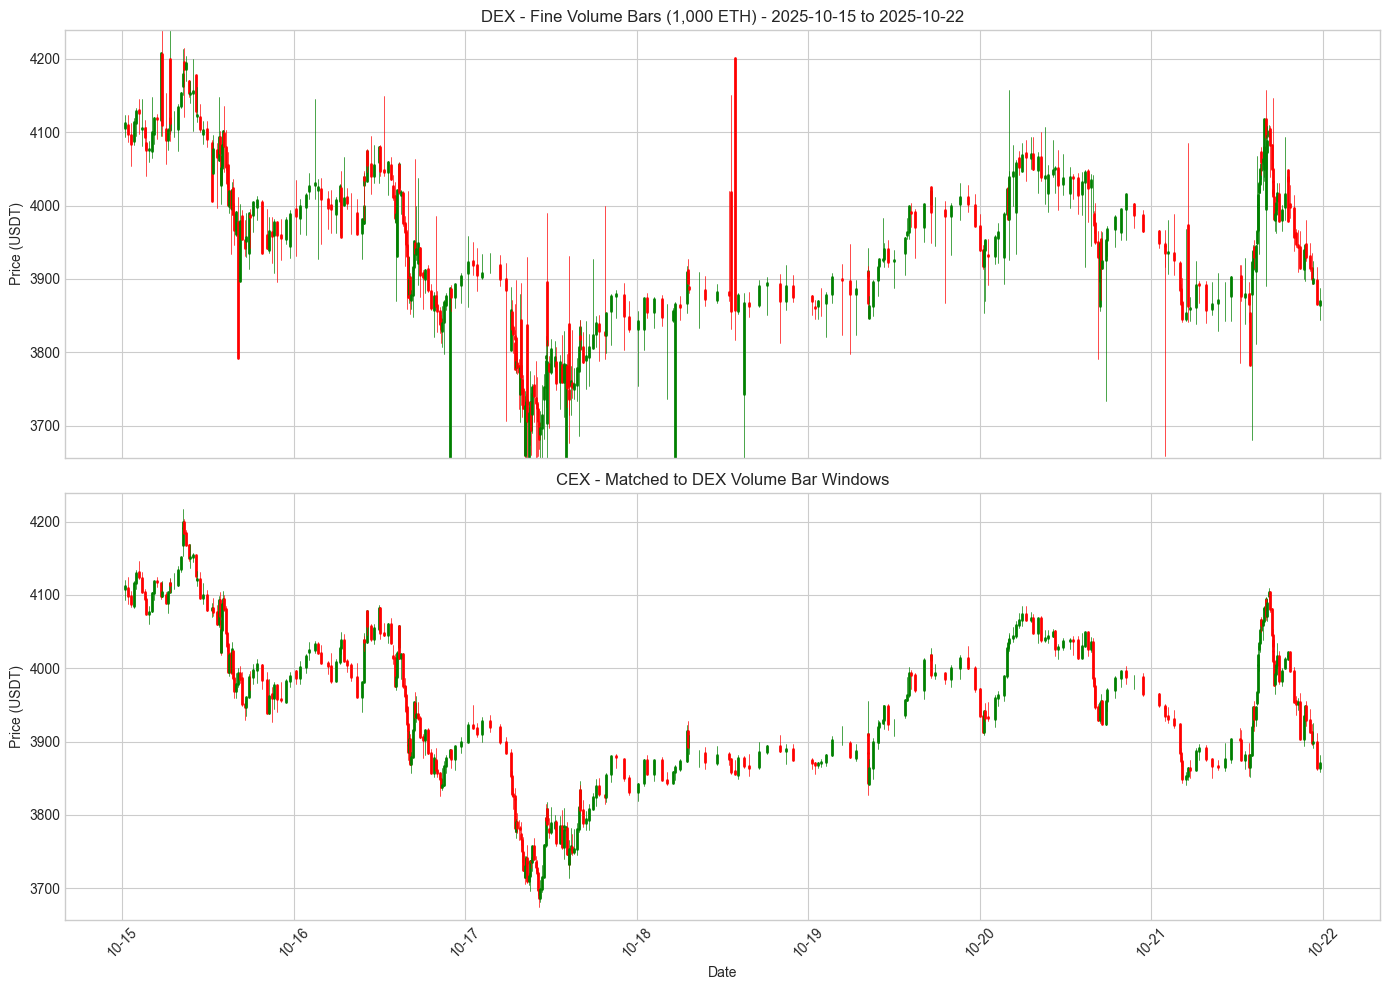

Showing 388 bars for 2025-10-15 to 2025-10-22


In [96]:
# Plot: Candlestick comparison for fine volume bars (sample one week)
sample_start = '2025-10-15'
sample_end = '2025-10-22'

mask = (candles_vol_fine['start_time'] >= sample_start) & (candles_vol_fine['start_time'] < sample_end)
candles_vol_fine_week = candles_vol_fine[mask]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

y_min = candles_vol_fine_week['low_cex'].min() * 0.995
y_max = candles_vol_fine_week['high_cex'].max() * 1.005

# DEX candlesticks
ax1 = axes[0]
for _, row in candles_vol_fine_week.iterrows():
    x = row['start_time']
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    ax1.plot([x, x], [row['low_dex'], row['high_dex']], color=color, linewidth=0.5)
    ax1.plot([x, x], [row['open_dex'], row['close_dex']], color=color, linewidth=2)

ax1.set_ylim(y_min, y_max)
ax1.set_ylabel('Price (USDT)')
ax1.set_title(f'DEX - Fine Volume Bars (1,000 ETH) - {sample_start} to {sample_end}')

# CEX candlesticks
ax2 = axes[1]
for _, row in candles_vol_fine_week.iterrows():
    x = row['start_time']
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    ax2.plot([x, x], [row['low_cex'], row['high_cex']], color=color, linewidth=0.5)
    ax2.plot([x, x], [row['open_cex'], row['close_cex']], color=color, linewidth=2)

ax2.set_ylim(y_min, y_max)
ax2.set_xlabel('Date')
ax2.set_ylabel('Price (USDT)')
ax2.set_title('CEX - Matched to DEX Volume Bar Windows')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Showing {len(candles_vol_fine_week)} bars for {sample_start} to {sample_end}")

In [97]:
# Save fine volume bars
candles_vol_fine.to_parquet('candles_vol_fine_dex_cex.parquet')
print("Saved: candles_vol_fine_dex_cex.parquet")

Saved: candles_vol_fine_dex_cex.parquet


## Section 8: Tick Bars (DEX-anchored)

Tick bars group trades by count rather than time or volume. Each bar contains a fixed number of trades, which can better capture market activity during high-volatility periods.

In [98]:
# Determine tick bar size
# Target similar bar count to 4h candles for comparability

total_dex_trades = len(dex)
target_bars = len(candles_4h)  # ~186 bars

tick_bar_size = total_dex_trades // target_bars

print(f"Total DEX trades (after dust filter): {total_dex_trades:,}")
print(f"Target bar count: {target_bars}")
print(f"Tick bar size: {tick_bar_size:,} trades per bar")

Total DEX trades (after dust filter): 611,093
Target bar count: 186
Tick bar size: 3,285 trades per bar


In [99]:
# Build DEX tick bars
dex_for_tick = dex.copy()
dex_for_tick = dex_for_tick.sort_values('timestamp').reset_index(drop=True)

# Assign bar ID based on cumulative trade count
dex_for_tick['trade_number'] = range(len(dex_for_tick))
dex_for_tick['bar'] = dex_for_tick['trade_number'] // tick_bar_size

# Aggregate into tick bars
dex_tick = dex_for_tick.groupby('bar').agg(
    open=('price_usdt_per_eth', 'first'),
    high=('price_usdt_per_eth', 'max'),
    low=('price_usdt_per_eth', 'min'),
    close=('price_usdt_per_eth', 'last'),
    volume_eth=('abs_eth_volume', 'sum'),
    volume_usdt=('abs_usdt_volume', 'sum'),
    trade_count=('price_usdt_per_eth', 'count'),
    start_time=('timestamp', lambda x: pd.to_datetime(x.iloc[0], unit='s')),
    end_time=('timestamp', lambda x: pd.to_datetime(x.iloc[-1], unit='s'))
)

# Calculate VWAP
dex_tick['vwap'] = dex_tick['volume_usdt'] / dex_tick['volume_eth']

# Duration in minutes
dex_tick['duration_min'] = (dex_tick['end_time'] - dex_tick['start_time']).dt.total_seconds() / 60

print(f"Built {len(dex_tick)} DEX tick bars")
print(f"Avg trades per bar: {dex_tick['trade_count'].mean():,.0f}")
print(f"Avg duration: {dex_tick['duration_min'].mean():,.1f} minutes")
print(f"Duration range: {dex_tick['duration_min'].min():,.1f} - {dex_tick['duration_min'].max():,.1f} minutes")

Built 187 DEX tick bars
Avg trades per bar: 3,268
Avg duration: 239.6 minutes
Duration range: 12.8 - 439.8 minutes


In [100]:
# Build CEX bars matched to DEX tick bar time windows
cex_tick_bars = []

for bar_id, row in dex_tick.iterrows():
    start = row['start_time']
    end = row['end_time']
    
    # Get CEX trades within this DEX bar's time window
    mask = (cex.index >= start) & (cex.index <= end)
    cex_window = cex.loc[mask]
    
    if len(cex_window) > 0:
        cex_tick_bars.append({
            'bar': bar_id,
            'open': cex_window['price'].iloc[0],
            'high': cex_window['price'].max(),
            'low': cex_window['price'].min(),
            'close': cex_window['price'].iloc[-1],
            'volume': cex_window['quantity'].sum(),
            'trade_count': len(cex_window),
            'vwap': (cex_window['price'] * cex_window['quantity']).sum() / cex_window['quantity'].sum()
        })
    else:
        # No CEX trades in this window - use NaN
        cex_tick_bars.append({
            'bar': bar_id,
            'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan,
            'volume': 0, 'trade_count': 0, 'vwap': np.nan
        })

cex_tick = pd.DataFrame(cex_tick_bars).set_index('bar')
print(f"Built {len(cex_tick)} CEX tick bars matched to DEX windows")
print(f"Bars with no CEX trades: {cex_tick['vwap'].isna().sum()}")

Built 187 CEX tick bars matched to DEX windows
Bars with no CEX trades: 1


In [101]:
# Merge DEX and CEX tick bars
candles_tick = pd.merge(
    dex_tick[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count', 'start_time', 'end_time', 'duration_min']],
    cex_tick[['open', 'high', 'low', 'close', 'vwap', 'volume', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex')
)

# Set start_time as index for time-series plots
candles_tick = candles_tick.set_index('start_time')

print(f"Merged tick bars: {len(candles_tick)}")
print(f"\n=== DEX Stats ===")
print(f"Avg volume per bar: {candles_tick['volume_eth'].mean():,.1f} ETH")
print(f"Avg trades per bar: {candles_tick['trade_count_dex'].mean():,.0f}")
print(f"\n=== CEX Stats ===")
print(f"Avg volume per bar: {candles_tick['volume'].mean():,.1f} ETH")
print(f"Avg trades per bar: {candles_tick['trade_count_cex'].mean():,.0f}")

Merged tick bars: 187

=== DEX Stats ===
Avg volume per bar: 10,273.7 ETH
Avg trades per bar: 3,268

=== CEX Stats ===
Avg volume per bar: 92,045.8 ETH
Avg trades per bar: 268,530


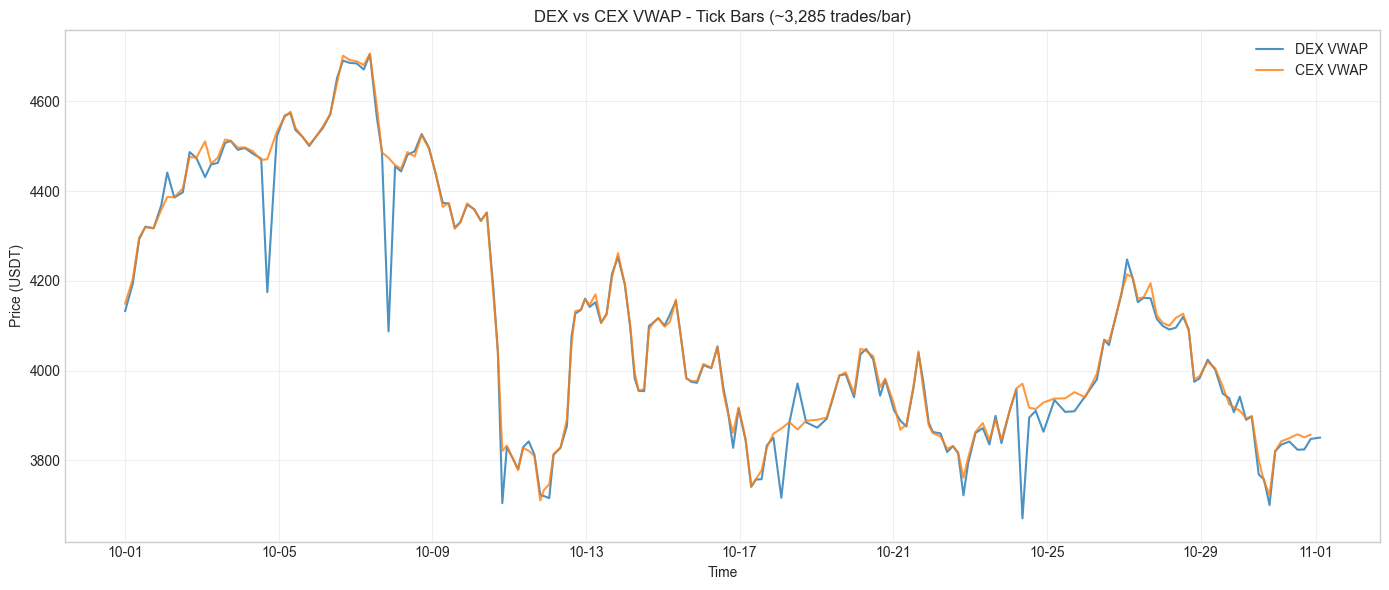

In [102]:
# Plot: VWAP comparison for tick bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(candles_tick.index, candles_tick['vwap_dex'], label='DEX VWAP', alpha=0.8)
ax.plot(candles_tick.index, candles_tick['vwap_cex'], label='CEX VWAP', alpha=0.8)

ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title(f'DEX vs CEX VWAP - Tick Bars (~{tick_bar_size:,} trades/bar)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()
plt.show()

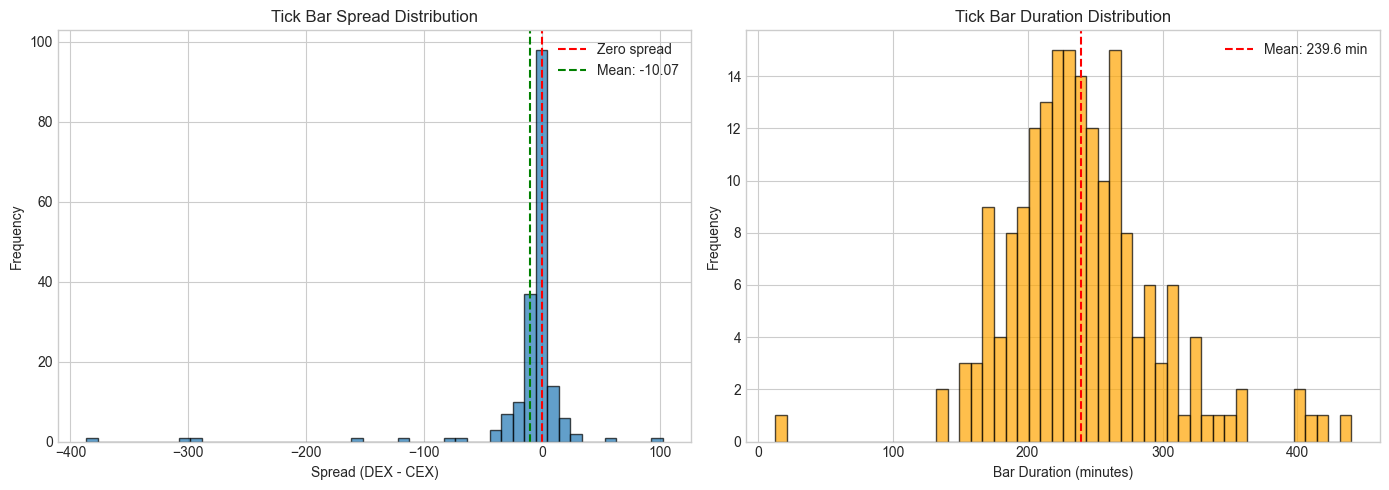


Spread stats: mean=-10.0716, std=46.0960


In [103]:
# Plot: Spread and bar duration distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spread distribution
spread_tick = candles_tick['vwap_dex'] - candles_tick['vwap_cex']
axes[0].hist(spread_tick.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero spread')
axes[0].axvline(x=spread_tick.mean(), color='green', linestyle='--', label=f'Mean: {spread_tick.mean():.2f}')
axes[0].set_xlabel('Spread (DEX - CEX)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tick Bar Spread Distribution')
axes[0].legend()

# Duration distribution
axes[1].hist(candles_tick['duration_min'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=candles_tick['duration_min'].mean(), color='red', linestyle='--', 
                label=f'Mean: {candles_tick["duration_min"].mean():.1f} min')
axes[1].set_xlabel('Bar Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Tick Bar Duration Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSpread stats: mean={spread_tick.mean():.4f}, std={spread_tick.std():.4f}")

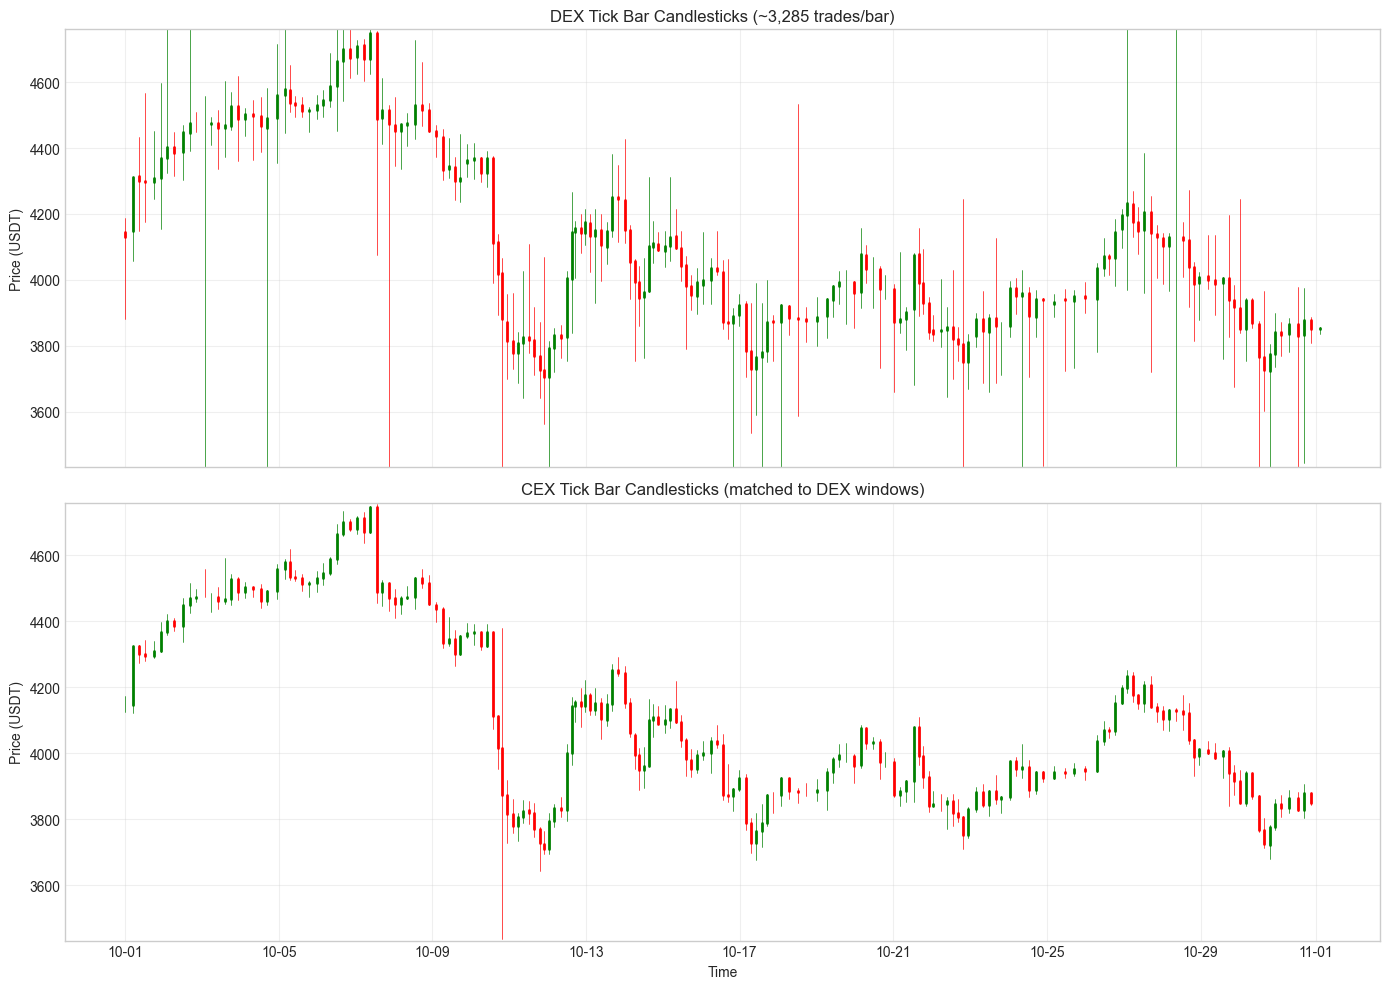

In [104]:
# Plot: Candlestick comparison for tick bars (matched y-axis)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Use CEX price range as reference for y-axis
y_min = candles_tick['low_cex'].min() * 0.999
y_max = candles_tick['high_cex'].max() * 1.001

# DEX candlesticks
for idx, row in candles_tick.iterrows():
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    # Clip high/low to y-axis range for display
    high_clipped = min(row['high_dex'], y_max)
    low_clipped = max(row['low_dex'], y_min)
    axes[0].plot([idx, idx], [low_clipped, high_clipped], color=color, linewidth=0.5)
    axes[0].plot([idx, idx], [row['open_dex'], row['close_dex']], color=color, linewidth=2)

axes[0].set_ylabel('Price (USDT)')
axes[0].set_title(f'DEX Tick Bar Candlesticks (~{tick_bar_size:,} trades/bar)')
axes[0].set_ylim(y_min, y_max)
axes[0].grid(True, alpha=0.3)

# CEX candlesticks
for idx, row in candles_tick.iterrows():
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    axes[1].plot([idx, idx], [row['low_cex'], row['high_cex']], color=color, linewidth=0.5)
    axes[1].plot([idx, idx], [row['open_cex'], row['close_cex']], color=color, linewidth=2)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price (USDT)')
axes[1].set_title(f'CEX Tick Bar Candlesticks (matched to DEX windows)')
axes[1].set_ylim(y_min, y_max)
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.tight_layout()
plt.show()

In [105]:
# Save tick bars
candles_tick.to_parquet('candles_tick_dex_cex.parquet')
print("Saved: candles_tick_dex_cex.parquet")

Saved: candles_tick_dex_cex.parquet


## Section 9: Fine Tick Bars (500 trades per bar)

Finer tick bars with ~500 trades per bar for higher resolution analysis.

In [106]:
# Build DEX fine tick bars at 500 trades per bar
tick_bar_size_fine = 500  # trades per bar

dex_for_tick_fine = dex.copy()
dex_for_tick_fine = dex_for_tick_fine.sort_values('timestamp').reset_index(drop=True)

# Assign bar ID based on cumulative trade count
dex_for_tick_fine['trade_number'] = range(len(dex_for_tick_fine))
dex_for_tick_fine['bar'] = dex_for_tick_fine['trade_number'] // tick_bar_size_fine

# Aggregate into tick bars
dex_tick_fine = dex_for_tick_fine.groupby('bar').agg(
    open=('price_usdt_per_eth', 'first'),
    high=('price_usdt_per_eth', 'max'),
    low=('price_usdt_per_eth', 'min'),
    close=('price_usdt_per_eth', 'last'),
    volume_eth=('abs_eth_volume', 'sum'),
    volume_usdt=('abs_usdt_volume', 'sum'),
    trade_count=('price_usdt_per_eth', 'count'),
    start_time=('timestamp', lambda x: pd.to_datetime(x.iloc[0], unit='s')),
    end_time=('timestamp', lambda x: pd.to_datetime(x.iloc[-1], unit='s'))
)

# Calculate VWAP
dex_tick_fine['vwap'] = dex_tick_fine['volume_usdt'] / dex_tick_fine['volume_eth']

# Duration in minutes
dex_tick_fine['duration_min'] = (dex_tick_fine['end_time'] - dex_tick_fine['start_time']).dt.total_seconds() / 60

print(f"Built {len(dex_tick_fine)} DEX fine tick bars")
print(f"Avg trades per bar: {dex_tick_fine['trade_count'].mean():,.0f}")
print(f"Avg duration: {dex_tick_fine['duration_min'].mean():,.1f} minutes")
print(f"Avg volume per bar: {dex_tick_fine['volume_eth'].mean():,.1f} ETH")

Built 1223 DEX fine tick bars
Avg trades per bar: 500
Avg duration: 36.6 minutes
Avg volume per bar: 1,570.9 ETH


In [107]:
# Build CEX bars matched to fine DEX tick bar windows
# Note: This may take a few minutes due to ~1,300 bars

cex_tick_fine_bars = []

for bar_id, row in dex_tick_fine.iterrows():
    start = row['start_time']
    end = row['end_time']
    
    mask = (cex.index >= start) & (cex.index <= end)
    cex_window = cex.loc[mask]
    
    if len(cex_window) > 0:
        cex_tick_fine_bars.append({
            'bar': bar_id,
            'open': cex_window['price'].iloc[0],
            'high': cex_window['price'].max(),
            'low': cex_window['price'].min(),
            'close': cex_window['price'].iloc[-1],
            'volume': cex_window['quantity'].sum(),
            'trade_count': len(cex_window),
            'vwap': (cex_window['price'] * cex_window['quantity']).sum() / cex_window['quantity'].sum()
        })
    else:
        cex_tick_fine_bars.append({
            'bar': bar_id,
            'open': np.nan, 'high': np.nan, 'low': np.nan, 'close': np.nan,
            'volume': 0, 'trade_count': 0, 'vwap': np.nan
        })

cex_tick_fine = pd.DataFrame(cex_tick_fine_bars).set_index('bar')
print(f"Built {len(cex_tick_fine)} CEX fine tick bars matched to DEX windows")
print(f"Bars with no CEX trades: {cex_tick_fine['vwap'].isna().sum()}")

Built 1223 CEX fine tick bars matched to DEX windows
Bars with no CEX trades: 4


In [108]:
# Merge fine tick bars
candles_tick_fine = pd.merge(
    dex_tick_fine[['open', 'high', 'low', 'close', 'vwap', 'volume_eth', 'trade_count', 'start_time', 'end_time', 'duration_min']],
    cex_tick_fine[['open', 'high', 'low', 'close', 'vwap', 'volume', 'trade_count']],
    left_index=True,
    right_index=True,
    suffixes=('_dex', '_cex')
)

candles_tick_fine = candles_tick_fine.set_index('start_time')

print(f"Merged fine tick bars: {len(candles_tick_fine)}")
print(f"\n=== DEX Stats ===")
print(f"Avg volume per bar: {candles_tick_fine['volume_eth'].mean():,.1f} ETH")
print(f"Avg duration: {candles_tick_fine['duration_min'].mean():,.1f} minutes")
print(f"\n=== CEX Stats ===")
print(f"Avg volume per bar: {candles_tick_fine['volume'].mean():,.1f} ETH")
print(f"Avg trades per bar: {candles_tick_fine['trade_count_cex'].mean():,.0f}")

Merged fine tick bars: 1223

=== DEX Stats ===
Avg volume per bar: 1,570.9 ETH
Avg duration: 36.6 minutes

=== CEX Stats ===
Avg volume per bar: 14,045.7 ETH
Avg trades per bar: 40,976


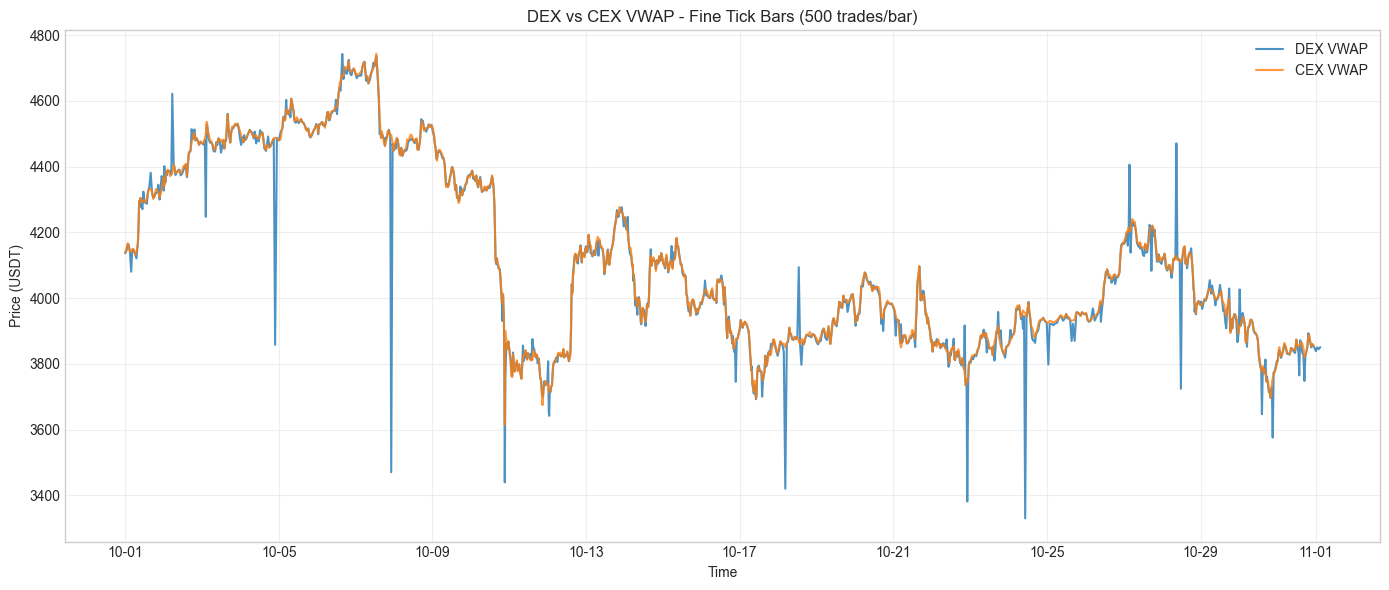

In [109]:
# Plot: VWAP comparison for fine tick bars
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(candles_tick_fine.index, candles_tick_fine['vwap_dex'], label='DEX VWAP', alpha=0.8)
ax.plot(candles_tick_fine.index, candles_tick_fine['vwap_cex'], label='CEX VWAP', alpha=0.8)

ax.set_xlabel('Time')
ax.set_ylabel('Price (USDT)')
ax.set_title(f'DEX vs CEX VWAP - Fine Tick Bars ({tick_bar_size_fine} trades/bar)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.tight_layout()
plt.show()

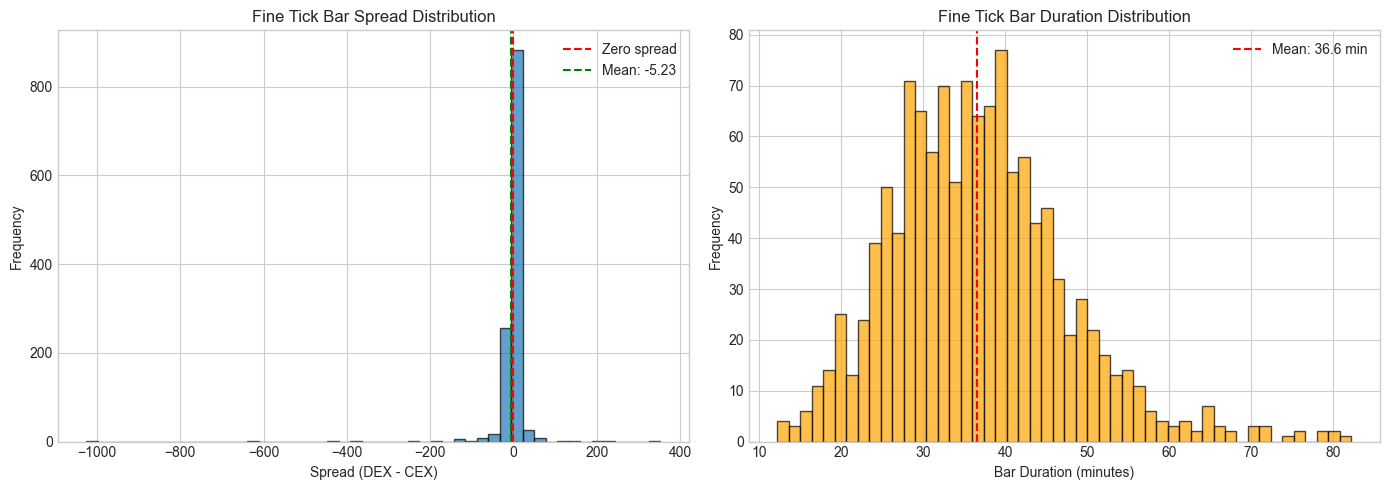


Spread stats: mean=-5.2326, std=49.6743


In [110]:
# Plot: Spread and duration for fine tick bars
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

spread_tick_fine = candles_tick_fine['vwap_dex'] - candles_tick_fine['vwap_cex']
axes[0].hist(spread_tick_fine.dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='Zero spread')
axes[0].axvline(x=spread_tick_fine.mean(), color='green', linestyle='--', label=f'Mean: {spread_tick_fine.mean():.2f}')
axes[0].set_xlabel('Spread (DEX - CEX)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Fine Tick Bar Spread Distribution')
axes[0].legend()

axes[1].hist(candles_tick_fine['duration_min'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(x=candles_tick_fine['duration_min'].mean(), color='red', linestyle='--',
                label=f'Mean: {candles_tick_fine["duration_min"].mean():.1f} min')
axes[1].set_xlabel('Bar Duration (minutes)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Fine Tick Bar Duration Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nSpread stats: mean={spread_tick_fine.mean():.4f}, std={spread_tick_fine.std():.4f}")

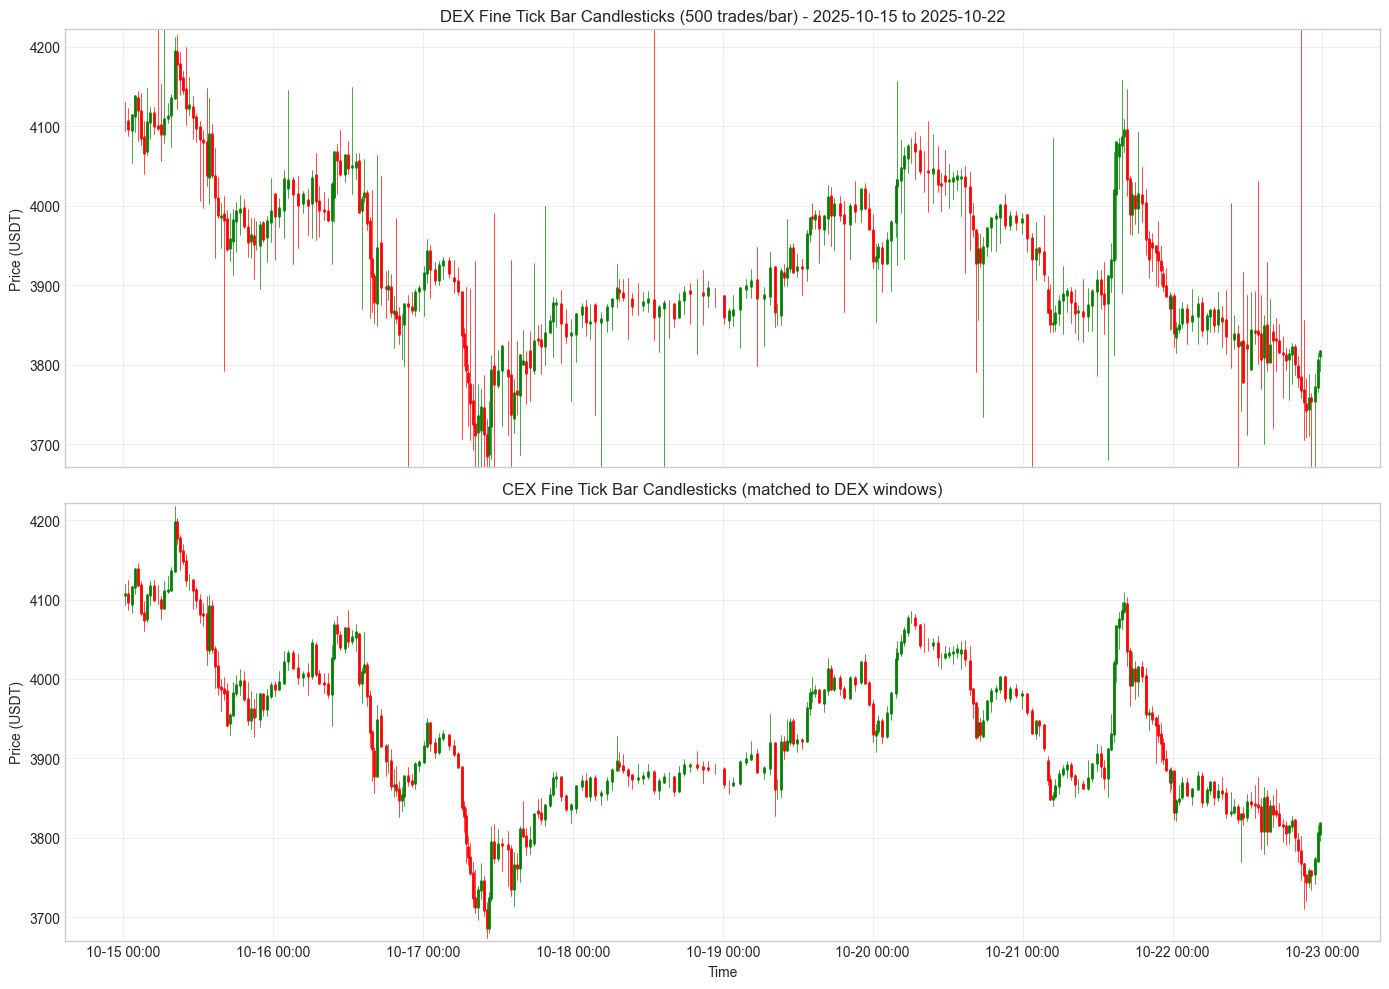

Showing 320 bars from 2025-10-15 to 2025-10-22


In [111]:
# Plot: Candlestick comparison for fine tick bars (sample one week)
sample_start = '2025-10-15'
sample_end = '2025-10-22'
sample_tick_fine = candles_tick_fine.loc[sample_start:sample_end]

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Use CEX price range as reference
y_min = sample_tick_fine['low_cex'].min() * 0.999
y_max = sample_tick_fine['high_cex'].max() * 1.001

# DEX candlesticks
for idx, row in sample_tick_fine.iterrows():
    color = 'green' if row['close_dex'] >= row['open_dex'] else 'red'
    high_clipped = min(row['high_dex'], y_max)
    low_clipped = max(row['low_dex'], y_min)
    axes[0].plot([idx, idx], [low_clipped, high_clipped], color=color, linewidth=0.5)
    axes[0].plot([idx, idx], [row['open_dex'], row['close_dex']], color=color, linewidth=2)

axes[0].set_ylabel('Price (USDT)')
axes[0].set_title(f'DEX Fine Tick Bar Candlesticks ({tick_bar_size_fine} trades/bar) - {sample_start} to {sample_end}')
axes[0].set_ylim(y_min, y_max)
axes[0].grid(True, alpha=0.3)

# CEX candlesticks
for idx, row in sample_tick_fine.iterrows():
    color = 'green' if row['close_cex'] >= row['open_cex'] else 'red'
    axes[1].plot([idx, idx], [row['low_cex'], row['high_cex']], color=color, linewidth=0.5)
    axes[1].plot([idx, idx], [row['open_cex'], row['close_cex']], color=color, linewidth=2)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price (USDT)')
axes[1].set_title('CEX Fine Tick Bar Candlesticks (matched to DEX windows)')
axes[1].set_ylim(y_min, y_max)
axes[1].grid(True, alpha=0.3)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))

plt.tight_layout()
plt.show()

print(f"Showing {len(sample_tick_fine)} bars from {sample_start} to {sample_end}")

In [112]:
# Save fine tick bars
candles_tick_fine.to_parquet('candles_tick_fine_dex_cex.parquet')
print("Saved: candles_tick_fine_dex_cex.parquet")

Saved: candles_tick_fine_dex_cex.parquet


## Section 10: Lead-Lag Analysis

This section performs econometric tests to determine price discovery dynamics between DEX and CEX:
1. **Stationarity tests (ADF)** - Verify data properties
2. **Granger causality** - Who predicts whom?
3. **Cointegration (Johansen)** - Long-run equilibrium relationship
4. **VECM** - Adjustment speeds to equilibrium
5. **Hasbrouck Information Shares** - Price discovery contribution

We run these tests on three fine-grained bar types:
- 1-minute time bars (~44K observations)
- Fine volume bars (1K ETH, ~1,900 observations)
- Fine tick bars (500 trades, ~1,300 observations)

In [113]:
# Install/import econometric libraries
%pip install statsmodels --quiet

from statsmodels.tsa.stattools import adfuller, grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.vector_ar.var_model import VAR
import warnings
warnings.filterwarnings('ignore')

print("Econometric libraries loaded")

Note: you may need to restart the kernel to use updated packages.
Econometric libraries loaded


In [114]:
# Load the three fine-grained datasets for analysis
datasets = {
    'time_1m': pd.read_parquet('candles_1m_dex_cex.parquet'),
    'volume_1k': pd.read_parquet('candles_vol_fine_dex_cex.parquet'),
    'tick_500': pd.read_parquet('candles_tick_fine_dex_cex.parquet')
}

# Display basic info
for name, df in datasets.items():
    print(f"{name}: {len(df)} observations, columns: {list(df.columns)[:5]}...")

time_1m: 44611 observations, columns: ['open_dex', 'high_dex', 'low_dex', 'close_dex', 'vwap_dex']...
volume_1k: 1878 observations, columns: ['open_dex', 'high_dex', 'low_dex', 'close_dex', 'vwap_dex']...
tick_500: 1223 observations, columns: ['open_dex', 'high_dex', 'low_dex', 'close_dex', 'vwap_dex']...


### 10.1 Stationarity Tests (ADF)

Before running Granger causality and VECM, we need to check:
- **Prices**: Expected to be non-stationary (unit root) → I(1)
- **Returns**: Expected to be stationary → I(0)

If prices are I(1) and cointegrated, we use VECM. For Granger causality, we use returns.

In [115]:
# ADF test function
def run_adf_test(series, name):
    """Run ADF test and return results"""
    result = adfuller(series.dropna(), autolag='AIC')
    return {
        'series': name,
        'adf_stat': result[0],
        'p_value': result[1],
        'lags': result[2],
        'stationary': result[1] < 0.05
    }

# Run ADF tests on all datasets
adf_results = []

for dataset_name, df in datasets.items():
    # Test VWAP prices (levels)
    adf_results.append(run_adf_test(df['vwap_dex'], f'{dataset_name}_dex_price'))
    adf_results.append(run_adf_test(df['vwap_cex'], f'{dataset_name}_cex_price'))
    
    # Test returns (first differences)
    dex_returns = df['vwap_dex'].pct_change().dropna()
    cex_returns = df['vwap_cex'].pct_change().dropna()
    adf_results.append(run_adf_test(dex_returns, f'{dataset_name}_dex_returns'))
    adf_results.append(run_adf_test(cex_returns, f'{dataset_name}_cex_returns'))

# Display results
adf_df = pd.DataFrame(adf_results)
print("=== ADF Stationarity Tests ===")
print("H0: Series has unit root (non-stationary)")
print("Reject H0 if p-value < 0.05\n")
print(adf_df.to_string(index=False))

=== ADF Stationarity Tests ===
H0: Series has unit root (non-stationary)
Reject H0 if p-value < 0.05

               series   adf_stat      p_value  lags  stationary
    time_1m_dex_price  -1.862989 3.496672e-01    18       False
    time_1m_cex_price  -1.379357 5.921315e-01    55       False
  time_1m_dex_returns -35.400767 0.000000e+00    46        True
  time_1m_cex_returns -30.106144 0.000000e+00    54        True
  volume_1k_dex_price  -1.777952 3.914616e-01     6       False
  volume_1k_cex_price  -1.801970 3.794841e-01    22       False
volume_1k_dex_returns -22.642099 0.000000e+00     5        True
volume_1k_cex_returns  -8.388274 2.405150e-13    21        True
   tick_500_dex_price  -1.649276 4.574179e-01     5       False
   tick_500_cex_price  -1.616705 4.744570e-01     8       False
 tick_500_dex_returns -21.707328 0.000000e+00     4        True
 tick_500_cex_returns -11.230939 1.908262e-20     7        True


### 10.2 Granger Causality Tests

Tests whether past values of one series help predict the other:
- **DEX → CEX**: Do past DEX returns predict future CEX returns?
- **CEX → DEX**: Do past CEX returns predict future DEX returns?

We use returns (stationary) and test multiple lag lengths.

In [116]:
# Granger causality test function
def run_granger_test(df, max_lag=5):
    """
    Run Granger causality tests in both directions.
    Returns results for the best lag (lowest p-value).
    """
    # Prepare returns data
    returns = pd.DataFrame({
        'dex': df['vwap_dex'].pct_change(),
        'cex': df['vwap_cex'].pct_change()
    }).dropna()
    
    results = {}
    
    # Test: DEX Granger-causes CEX (do past DEX returns predict CEX?)
    # In statsmodels: grangercausalitytests(data, maxlag) tests if 2nd column causes 1st
    try:
        gc_dex_to_cex = grangercausalitytests(returns[['cex', 'dex']], maxlag=max_lag, verbose=False)
        # Get best lag (lowest p-value)
        best_lag_d2c = min(gc_dex_to_cex.keys(), 
                          key=lambda x: gc_dex_to_cex[x][0]['ssr_ftest'][1])
        results['dex_causes_cex'] = {
            'best_lag': best_lag_d2c,
            'f_stat': gc_dex_to_cex[best_lag_d2c][0]['ssr_ftest'][0],
            'p_value': gc_dex_to_cex[best_lag_d2c][0]['ssr_ftest'][1]
        }
    except Exception as e:
        results['dex_causes_cex'] = {'error': str(e)}
    
    # Test: CEX Granger-causes DEX
    try:
        gc_cex_to_dex = grangercausalitytests(returns[['dex', 'cex']], maxlag=max_lag, verbose=False)
        best_lag_c2d = min(gc_cex_to_dex.keys(),
                          key=lambda x: gc_cex_to_dex[x][0]['ssr_ftest'][1])
        results['cex_causes_dex'] = {
            'best_lag': best_lag_c2d,
            'f_stat': gc_cex_to_dex[best_lag_c2d][0]['ssr_ftest'][0],
            'p_value': gc_cex_to_dex[best_lag_c2d][0]['ssr_ftest'][1]
        }
    except Exception as e:
        results['cex_causes_dex'] = {'error': str(e)}
    
    return results

# Run Granger tests on all datasets
granger_results = {}
for name, df in datasets.items():
    granger_results[name] = run_granger_test(df, max_lag=10)

# Display results
print("=== Granger Causality Tests ===")
print("H0: X does not Granger-cause Y")
print("Reject H0 if p-value < 0.05 (X helps predict Y)\n")

for name, result in granger_results.items():
    print(f"\n--- {name} ---")
    if 'error' not in result.get('dex_causes_cex', {}):
        d2c = result['dex_causes_cex']
        sig_d2c = "***" if d2c['p_value'] < 0.01 else "**" if d2c['p_value'] < 0.05 else ""
        print(f"DEX → CEX: F={d2c['f_stat']:.2f}, p={d2c['p_value']:.4f} (lag={d2c['best_lag']}) {sig_d2c}")
    if 'error' not in result.get('cex_causes_dex', {}):
        c2d = result['cex_causes_dex']
        sig_c2d = "***" if c2d['p_value'] < 0.01 else "**" if c2d['p_value'] < 0.05 else ""
        print(f"CEX → DEX: F={c2d['f_stat']:.2f}, p={c2d['p_value']:.4f} (lag={c2d['best_lag']}) {sig_c2d}")

=== Granger Causality Tests ===
H0: X does not Granger-cause Y
Reject H0 if p-value < 0.05 (X helps predict Y)


--- time_1m ---
DEX → CEX: F=8.06, p=0.0000 (lag=9) ***
CEX → DEX: F=845.90, p=0.0000 (lag=2) ***

--- volume_1k ---
DEX → CEX: F=1.05, p=0.3058 (lag=1) 
CEX → DEX: F=32.00, p=0.0000 (lag=8) ***

--- tick_500 ---
DEX → CEX: F=1.28, p=0.2588 (lag=1) 
CEX → DEX: F=28.65, p=0.0000 (lag=9) ***


### 10.3 Cointegration Test (Johansen)

Tests whether DEX and CEX prices share a long-run equilibrium relationship.
- If cointegrated: prices may diverge short-term but revert to equilibrium
- This is a prerequisite for VECM estimation

In [117]:
# Johansen cointegration test
def run_johansen_test(df, det_order=0, k_ar_diff=1):
    """
    Run Johansen cointegration test.
    det_order: -1 (no deterministic), 0 (constant), 1 (trend)
    Returns trace and max eigenvalue statistics.
    """
    prices = df[['vwap_dex', 'vwap_cex']].dropna()
    
    result = coint_johansen(prices, det_order=det_order, k_ar_diff=k_ar_diff)
    
    # Trace test
    trace_stat = result.lr1  # Trace statistics
    trace_crit = result.cvt  # Critical values (90%, 95%, 99%)
    
    # Max eigenvalue test
    max_stat = result.lr2
    max_crit = result.cvm
    
    return {
        'trace_stat_r0': trace_stat[0],  # Test r=0 (no cointegration)
        'trace_crit_95_r0': trace_crit[0, 1],  # 95% critical value
        'trace_stat_r1': trace_stat[1],  # Test r≤1
        'trace_crit_95_r1': trace_crit[1, 1],
        'max_stat_r0': max_stat[0],
        'max_crit_95_r0': max_crit[0, 1],
        'cointegrated': trace_stat[0] > trace_crit[0, 1]  # Reject r=0 at 95%
    }

# Run Johansen test on all datasets
johansen_results = {}
for name, df in datasets.items():
    johansen_results[name] = run_johansen_test(df)

# Display results
print("=== Johansen Cointegration Test ===")
print("H0: r=0 (no cointegrating relationship)")
print("Reject H0 if trace statistic > critical value\n")

for name, result in johansen_results.items():
    coint_status = "COINTEGRATED" if result['cointegrated'] else "NOT cointegrated"
    print(f"--- {name} ---")
    print(f"  Trace stat (r=0): {result['trace_stat_r0']:.2f} vs critical 95%: {result['trace_crit_95_r0']:.2f}")
    print(f"  Trace stat (r≤1): {result['trace_stat_r1']:.2f} vs critical 95%: {result['trace_crit_95_r1']:.2f}")
    print(f"  Result: {coint_status}\n")

=== Johansen Cointegration Test ===
H0: r=0 (no cointegrating relationship)
Reject H0 if trace statistic > critical value

--- time_1m ---
  Trace stat (r=0): 10376.62 vs critical 95%: 15.49
  Trace stat (r≤1): 2.53 vs critical 95%: 3.84
  Result: COINTEGRATED

--- volume_1k ---
  Trace stat (r=0): 422.02 vs critical 95%: 15.49
  Trace stat (r≤1): 2.57 vs critical 95%: 3.84
  Result: COINTEGRATED

--- tick_500 ---
  Trace stat (r=0): 490.45 vs critical 95%: 15.49
  Trace stat (r≤1): 2.24 vs critical 95%: 3.84
  Result: COINTEGRATED



### 10.4 Vector Error Correction Model (VECM)

If prices are cointegrated, VECM estimates how each market adjusts to deviations from equilibrium:
- **α (alpha)**: Adjustment coefficients
- The market with larger |α| adjusts faster → it's the "follower"
- The market with smaller |α| (closer to 0) is the "leader"

In [118]:
# VECM estimation
def run_vecm(df, k_ar_diff=1, coint_rank=1):
    """
    Estimate VECM and extract adjustment coefficients.
    """
    prices = df[['vwap_dex', 'vwap_cex']].dropna()
    
    try:
        model = VECM(prices, k_ar_diff=k_ar_diff, coint_rank=coint_rank, deterministic='ci')
        results = model.fit()
        
        # Adjustment coefficients (alpha)
        alpha = results.alpha
        
        return {
            'alpha_dex': alpha[0, 0],  # DEX adjustment speed
            'alpha_cex': alpha[1, 0],  # CEX adjustment speed
            'alpha_dex_pval': results.pvalues_alpha[0, 0],
            'alpha_cex_pval': results.pvalues_alpha[1, 0],
            'beta': results.beta[:, 0],  # Cointegrating vector
            'success': True
        }
    except Exception as e:
        return {'success': False, 'error': str(e)}

# Run VECM on all datasets
vecm_results = {}
for name, df in datasets.items():
    vecm_results[name] = run_vecm(df)

# Display results
print("=== VECM Adjustment Coefficients ===")
print("α (alpha): Speed of adjustment to equilibrium")
print("Larger |α| = faster adjustment = follower")
print("Smaller |α| = slower adjustment = leader\n")

for name, result in vecm_results.items():
    print(f"--- {name} ---")
    if result['success']:
        alpha_dex = result['alpha_dex']
        alpha_cex = result['alpha_cex']
        
        # Interpret who leads
        if abs(alpha_dex) > abs(alpha_cex):
            leader = "CEX leads (DEX adjusts faster)"
        else:
            leader = "DEX leads (CEX adjusts faster)"
        
        sig_dex = "***" if result['alpha_dex_pval'] < 0.01 else "**" if result['alpha_dex_pval'] < 0.05 else ""
        sig_cex = "***" if result['alpha_cex_pval'] < 0.01 else "**" if result['alpha_cex_pval'] < 0.05 else ""
        
        print(f"  α_DEX: {alpha_dex:.6f} (p={result['alpha_dex_pval']:.4f}) {sig_dex}")
        print(f"  α_CEX: {alpha_cex:.6f} (p={result['alpha_cex_pval']:.4f}) {sig_cex}")
        print(f"  → {leader}\n")
    else:
        print(f"  Error: {result['error']}\n")

=== VECM Adjustment Coefficients ===
α (alpha): Speed of adjustment to equilibrium
Larger |α| = faster adjustment = follower
Smaller |α| = slower adjustment = leader

--- time_1m ---
  α_DEX: -0.617154 (p=0.0000) ***
  α_CEX: -0.005110 (p=0.0009) ***
  → CEX leads (DEX adjusts faster)

--- volume_1k ---
  α_DEX: -0.573091 (p=0.0000) ***
  α_CEX: -0.012566 (p=0.1440) 
  → CEX leads (DEX adjusts faster)

--- tick_500 ---
  α_DEX: -0.990116 (p=0.0000) ***
  α_CEX: -0.004379 (p=0.8017) 
  → CEX leads (DEX adjusts faster)



### 10.5 Hasbrouck Information Shares

Decomposes the contribution of each market to the variance of the efficient (common) price:
- Based on the VECM residuals and cointegrating vector
- Returns upper and lower bounds (due to correlation in residuals)
- Higher share = greater contribution to price discovery

In [119]:
# Hasbrouck Information Shares calculation
def calculate_hasbrouck_shares(df, k_ar_diff=1):
    """
    Calculate Hasbrouck (1995) information shares.
    
    Information share = contribution to variance of efficient price.
    Returns upper and lower bounds due to contemporaneous correlation.
    """
    prices = df[['vwap_dex', 'vwap_cex']].dropna()
    
    try:
        # Fit VECM
        model = VECM(prices, k_ar_diff=k_ar_diff, coint_rank=1, deterministic='ci')
        results = model.fit()
        
        # Get residual covariance matrix
        resid = results.resid
        omega = np.cov(resid.T)  # 2x2 covariance matrix
        
        # Get the orthogonal complement of beta (gamma)
        # For 2 variables with 1 cointegrating vector, gamma is perpendicular to beta
        beta = results.beta[:, 0]
        
        # Gamma is proportional to [1, 1] for price discovery (both contribute to efficient price)
        # But we derive it from alpha: gamma is orthogonal to alpha
        alpha = results.alpha[:, 0]
        
        # The common factor weights (Gonzalo-Granger approach for gamma)
        # gamma is proportional to alpha_perp, where alpha_perp @ alpha = 0
        # For 2x1 alpha, alpha_perp = [-alpha[1], alpha[0]]
        gamma = np.array([-alpha[1], alpha[0]])
        gamma = gamma / np.sum(gamma)  # Normalize to sum to 1
        
        # Hasbrouck information shares using Cholesky decomposition
        # We need to compute shares for both orderings to get bounds
        
        # Cholesky of omega (lower triangular)
        try:
            F = np.linalg.cholesky(omega)
        except:
            # If not positive definite, use eigenvalue decomposition
            eigvals, eigvecs = np.linalg.eigh(omega)
            eigvals = np.maximum(eigvals, 1e-10)
            F = eigvecs @ np.diag(np.sqrt(eigvals))
        
        # Psi = long-run impact matrix = gamma' (for random walk component)
        # Information share for market i = (gamma[i] * F[i,:])^2 / (gamma @ omega @ gamma)
        
        psi = gamma  # Long-run multiplier
        
        # Total variance of efficient price innovation
        var_efficient = psi @ omega @ psi
        
        # Shares with original ordering (DEX first)
        psi_F = psi @ F
        share_dex_lower = (psi_F[0]**2) / var_efficient
        share_cex_lower = (psi_F[1]**2) / var_efficient
        
        # Shares with reversed ordering (CEX first) - swap rows/cols
        omega_swap = omega[[1,0]][:, [1,0]]
        try:
            F_swap = np.linalg.cholesky(omega_swap)
        except:
            eigvals, eigvecs = np.linalg.eigh(omega_swap)
            eigvals = np.maximum(eigvals, 1e-10)
            F_swap = eigvecs @ np.diag(np.sqrt(eigvals))
        
        psi_swap = psi[[1,0]]
        psi_F_swap = psi_swap @ F_swap
        share_cex_upper = (psi_F_swap[0]**2) / var_efficient
        share_dex_upper = (psi_F_swap[1]**2) / var_efficient
        
        # Midpoint estimates
        share_dex_mid = (share_dex_lower + share_dex_upper) / 2
        share_cex_mid = (share_cex_lower + share_cex_upper) / 2
        
        return {
            'dex_lower': min(share_dex_lower, share_dex_upper),
            'dex_upper': max(share_dex_lower, share_dex_upper),
            'dex_mid': share_dex_mid,
            'cex_lower': min(share_cex_lower, share_cex_upper),
            'cex_upper': max(share_cex_lower, share_cex_upper),
            'cex_mid': share_cex_mid,
            'gamma': gamma,
            'success': True
        }
    except Exception as e:
        return {'success': False, 'error': str(e)}

# Calculate Hasbrouck shares for all datasets
hasbrouck_results = {}
for name, df in datasets.items():
    hasbrouck_results[name] = calculate_hasbrouck_shares(df)

# Display results
print("=== Hasbrouck Information Shares ===")
print("Share = contribution to efficient price variance")
print("Higher share = greater price discovery contribution\n")

for name, result in hasbrouck_results.items():
    print(f"--- {name} ---")
    if result['success']:
        print(f"  DEX: {result['dex_mid']*100:.1f}% [{result['dex_lower']*100:.1f}% - {result['dex_upper']*100:.1f}%]")
        print(f"  CEX: {result['cex_mid']*100:.1f}% [{result['cex_lower']*100:.1f}% - {result['cex_upper']*100:.1f}%]")
        
        if result['dex_mid'] > result['cex_mid']:
            print(f"  → DEX contributes more to price discovery\n")
        else:
            print(f"  → CEX contributes more to price discovery\n")
    else:
        print(f"  Error: {result['error']}\n")

=== Hasbrouck Information Shares ===
Share = contribution to efficient price variance
Higher share = greater price discovery contribution

--- time_1m ---
  DEX: 1.3% [0.1% - 2.4%]
  CEX: 98.7% [97.6% - 99.9%]
  → CEX contributes more to price discovery

--- volume_1k ---
  DEX: 2.0% [0.5% - 3.6%]
  CEX: 98.0% [96.4% - 99.5%]
  → CEX contributes more to price discovery

--- tick_500 ---
  DEX: 6.9% [0.0% - 13.7%]
  CEX: 93.1% [86.3% - 100.0%]
  → CEX contributes more to price discovery



## Section 11: Comparison Across Bar Types

Summary of lead-lag analysis results across the three sampling methods:
- 1-minute time bars
- Volume bars (1,000 ETH)
- Tick bars (500 trades)

In [120]:
# Build summary table
summary_data = []

for name in datasets.keys():
    row = {'bar_type': name, 'n_obs': len(datasets[name])}
    
    # Granger causality
    if 'error' not in granger_results[name].get('dex_causes_cex', {}):
        row['granger_dex_to_cex_p'] = granger_results[name]['dex_causes_cex']['p_value']
        row['granger_dex_to_cex_sig'] = granger_results[name]['dex_causes_cex']['p_value'] < 0.05
    if 'error' not in granger_results[name].get('cex_causes_dex', {}):
        row['granger_cex_to_dex_p'] = granger_results[name]['cex_causes_dex']['p_value']
        row['granger_cex_to_dex_sig'] = granger_results[name]['cex_causes_dex']['p_value'] < 0.05
    
    # Cointegration
    row['cointegrated'] = johansen_results[name]['cointegrated']
    
    # VECM
    if vecm_results[name]['success']:
        row['alpha_dex'] = vecm_results[name]['alpha_dex']
        row['alpha_cex'] = vecm_results[name]['alpha_cex']
        row['vecm_leader'] = 'CEX' if abs(vecm_results[name]['alpha_dex']) > abs(vecm_results[name]['alpha_cex']) else 'DEX'
    
    # Hasbrouck
    if hasbrouck_results[name]['success']:
        row['hasbrouck_dex'] = hasbrouck_results[name]['dex_mid']
        row['hasbrouck_cex'] = hasbrouck_results[name]['cex_mid']
        row['hasbrouck_leader'] = 'DEX' if hasbrouck_results[name]['dex_mid'] > hasbrouck_results[name]['cex_mid'] else 'CEX'
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)

# Display summary
print("=== Summary: Lead-Lag Analysis Across Bar Types ===\n")
print(summary_df[['bar_type', 'n_obs', 'cointegrated', 'vecm_leader', 'hasbrouck_leader']].to_string(index=False))

=== Summary: Lead-Lag Analysis Across Bar Types ===

 bar_type  n_obs  cointegrated vecm_leader hasbrouck_leader
  time_1m  44611          True         CEX              CEX
volume_1k   1878          True         CEX              CEX
 tick_500   1223          True         CEX              CEX


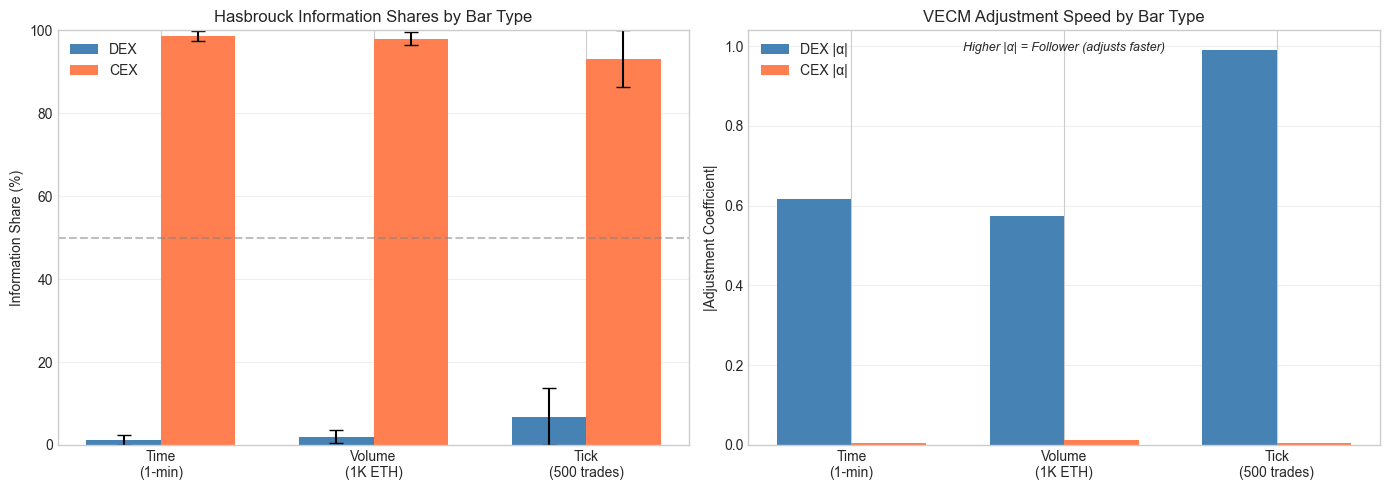

In [121]:
# Visualization: Information Shares Across Bar Types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bar_names = list(datasets.keys())
x = np.arange(len(bar_names))
width = 0.35

# Plot 1: Hasbrouck Information Shares
dex_shares = [hasbrouck_results[n]['dex_mid'] * 100 if hasbrouck_results[n]['success'] else 0 for n in bar_names]
cex_shares = [hasbrouck_results[n]['cex_mid'] * 100 if hasbrouck_results[n]['success'] else 0 for n in bar_names]

# Error bars (range from lower to upper)
dex_err_low = [hasbrouck_results[n]['dex_mid'] - hasbrouck_results[n]['dex_lower'] if hasbrouck_results[n]['success'] else 0 for n in bar_names]
dex_err_high = [hasbrouck_results[n]['dex_upper'] - hasbrouck_results[n]['dex_mid'] if hasbrouck_results[n]['success'] else 0 for n in bar_names]
cex_err_low = [hasbrouck_results[n]['cex_mid'] - hasbrouck_results[n]['cex_lower'] if hasbrouck_results[n]['success'] else 0 for n in bar_names]
cex_err_high = [hasbrouck_results[n]['cex_upper'] - hasbrouck_results[n]['cex_mid'] if hasbrouck_results[n]['success'] else 0 for n in bar_names]

bars1 = axes[0].bar(x - width/2, dex_shares, width, label='DEX', color='steelblue',
                    yerr=[np.array(dex_err_low)*100, np.array(dex_err_high)*100], capsize=5)
bars2 = axes[0].bar(x + width/2, cex_shares, width, label='CEX', color='coral',
                    yerr=[np.array(cex_err_low)*100, np.array(cex_err_high)*100], capsize=5)

axes[0].set_ylabel('Information Share (%)')
axes[0].set_title('Hasbrouck Information Shares by Bar Type')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['Time\n(1-min)', 'Volume\n(1K ETH)', 'Tick\n(500 trades)'])
axes[0].legend()
axes[0].axhline(y=50, color='gray', linestyle='--', alpha=0.5)
axes[0].set_ylim(0, 100)
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: VECM Adjustment Coefficients
alpha_dex = [abs(vecm_results[n]['alpha_dex']) if vecm_results[n]['success'] else 0 for n in bar_names]
alpha_cex = [abs(vecm_results[n]['alpha_cex']) if vecm_results[n]['success'] else 0 for n in bar_names]

bars3 = axes[1].bar(x - width/2, alpha_dex, width, label='DEX |α|', color='steelblue')
bars4 = axes[1].bar(x + width/2, alpha_cex, width, label='CEX |α|', color='coral')

axes[1].set_ylabel('|Adjustment Coefficient|')
axes[1].set_title('VECM Adjustment Speed by Bar Type')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Time\n(1-min)', 'Volume\n(1K ETH)', 'Tick\n(500 trades)'])
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# Add annotation: higher |α| = faster adjustment = follower
axes[1].text(0.5, 0.95, 'Higher |α| = Follower (adjusts faster)', 
             transform=axes[1].transAxes, ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

In [122]:
# Detailed Granger Causality Summary
print("=== Granger Causality Detailed Results ===\n")
print(f"{'Bar Type':<12} {'DEX→CEX p-val':<16} {'CEX→DEX p-val':<16} {'Interpretation'}")
print("-" * 70)

for name in bar_names:
    d2c_p = granger_results[name]['dex_causes_cex']['p_value']
    c2d_p = granger_results[name]['cex_causes_dex']['p_value']
    
    d2c_sig = d2c_p < 0.05
    c2d_sig = c2d_p < 0.05
    
    if d2c_sig and c2d_sig:
        interp = "Bidirectional causality"
    elif d2c_sig:
        interp = "DEX leads CEX"
    elif c2d_sig:
        interp = "CEX leads DEX"
    else:
        interp = "No significant causality"
    
    print(f"{name:<12} {d2c_p:<16.4f} {c2d_p:<16.4f} {interp}")

=== Granger Causality Detailed Results ===

Bar Type     DEX→CEX p-val    CEX→DEX p-val    Interpretation
----------------------------------------------------------------------
time_1m      0.0000           0.0000           Bidirectional causality
volume_1k    0.3058           0.0000           CEX leads DEX
tick_500     0.2588           0.0000           CEX leads DEX


### Key Findings

**Interpretation Guide:**
- **Granger Causality**: Tests short-term predictability. If DEX→CEX is significant, past DEX returns help predict future CEX returns.
- **VECM α (alpha)**: The market with larger |α| adjusts faster to equilibrium → it's the "follower". Smaller |α| → "leader".
- **Hasbrouck Information Shares**: Proportion of efficient price variance attributable to each market. Higher share = greater contribution to price discovery.

**Consistency Check**: If results are consistent across methods and bar types, conclusions are more robust. If they differ, the sampling method affects the lead-lag relationship detected.

## Section 12: High-Frequency Cross-Correlation Analysis

The coarser bar types (volume, tick) may miss lead-lag dynamics that happen within seconds to minutes. This section uses **1-minute time bars** to examine cross-correlations at multiple lags.

If CEX leads DEX, we expect:
- `corr(DEX[t], CEX[t-k])` to be positive for small positive k (CEX moved k minutes ago, DEX follows now)
- `corr(CEX[t], DEX[t-k])` to be weak or zero (DEX doesn't predict CEX)

In [126]:
# Load 1-minute candles
candles_1m = pd.read_parquet('candles_1m_dex_cex.parquet')

# Compute returns
candles_1m['ret_dex'] = candles_1m['vwap_dex'].pct_change()
candles_1m['ret_cex'] = candles_1m['vwap_cex'].pct_change()

print(f"1-minute bars: {len(candles_1m)} observations")
print(f"Time span: {candles_1m.index.min()} to {candles_1m.index.max()}")

1-minute bars: 44611 observations
Time span: 2025-10-01 00:00:00 to 2025-10-31 23:59:00


In [127]:
# Compute cross-correlations at multiple lags
# Positive lag k: corr(DEX[t], CEX[t-k]) - does CEX k minutes ago predict DEX now?
# Negative lag k: corr(DEX[t], CEX[t+|k|]) - does DEX now predict CEX in the future? (equivalently: does DEX lead?)

max_lag = 10  # minutes
lags = range(-max_lag, max_lag + 1)

cross_corr_cex_leads = []  # corr(DEX[t], CEX[t-k])
cross_corr_dex_leads = []  # corr(CEX[t], DEX[t-k])

for k in lags:
    if k >= 0:
        # CEX at t-k vs DEX at t
        corr_val = candles_1m['ret_dex'].corr(candles_1m['ret_cex'].shift(k))
    else:
        # CEX at t vs DEX at t-|k| (i.e., DEX leads by |k|)
        corr_val = candles_1m['ret_dex'].shift(-k).corr(candles_1m['ret_cex'])
    cross_corr_cex_leads.append(corr_val)
    
    if k >= 0:
        # DEX at t-k vs CEX at t
        corr_val2 = candles_1m['ret_cex'].corr(candles_1m['ret_dex'].shift(k))
    else:
        corr_val2 = candles_1m['ret_cex'].shift(-k).corr(candles_1m['ret_dex'])
    cross_corr_dex_leads.append(corr_val2)

# Create results dataframe
xcorr_df = pd.DataFrame({
    'lag': list(lags),
    'corr_DEX_t_vs_CEX_t-k': cross_corr_cex_leads,
    'corr_CEX_t_vs_DEX_t-k': cross_corr_dex_leads
})

print("Cross-correlations at each lag:")
print(xcorr_df.to_string(index=False))

Cross-correlations at each lag:
 lag  corr_DEX_t_vs_CEX_t-k  corr_CEX_t_vs_DEX_t-k
 -10              -0.004090               0.000087
  -9              -0.003782               0.010767
  -8              -0.006067               0.005818
  -7               0.001455              -0.009121
  -6               0.009040               0.010172
  -5               0.009685               0.027924
  -4               0.001842               0.007519
  -3              -0.000871               0.008017
  -2              -0.001823               0.016611
  -1               0.039492               0.050070
   0               0.143358               0.143358
   1               0.050070               0.039492
   2               0.016611              -0.001823
   3               0.008017              -0.000871
   4               0.007519               0.001842
   5               0.027924               0.009685
   6               0.010172               0.009040
   7              -0.009121               0.001455

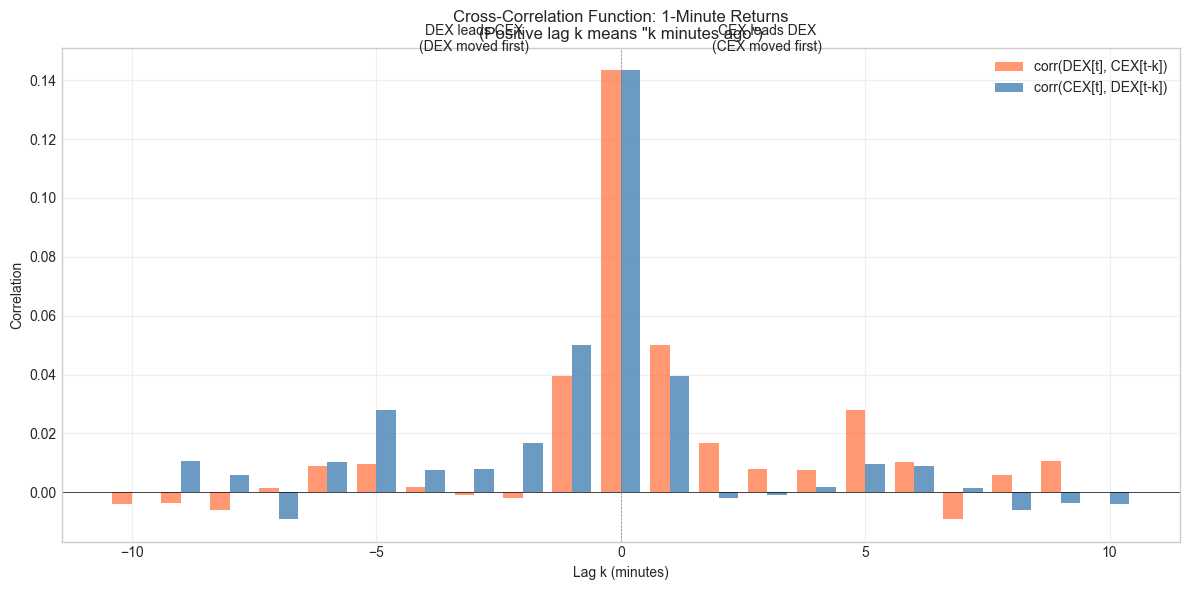

In [128]:
# Visualize cross-correlation function
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(xcorr_df['lag'] - 0.2, xcorr_df['corr_DEX_t_vs_CEX_t-k'], width=0.4, 
       label='corr(DEX[t], CEX[t-k])', color='coral', alpha=0.8)
ax.bar(xcorr_df['lag'] + 0.2, xcorr_df['corr_CEX_t_vs_DEX_t-k'], width=0.4,
       label='corr(CEX[t], DEX[t-k])', color='steelblue', alpha=0.8)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)

ax.set_xlabel('Lag k (minutes)')
ax.set_ylabel('Correlation')
ax.set_title('Cross-Correlation Function: 1-Minute Returns\n(Positive lag k means "k minutes ago")')
ax.legend()
ax.grid(True, alpha=0.3)

# Add annotations
ax.annotate('CEX leads DEX\n(CEX moved first)', xy=(3, 0.15), fontsize=10, ha='center')
ax.annotate('DEX leads CEX\n(DEX moved first)', xy=(-3, 0.15), fontsize=10, ha='center')

plt.tight_layout()
plt.show()

In [129]:
# Find the peak correlation and its lag
peak_cex_leads_idx = xcorr_df['corr_DEX_t_vs_CEX_t-k'].abs().idxmax()
peak_cex_leads_lag = xcorr_df.loc[peak_cex_leads_idx, 'lag']
peak_cex_leads_corr = xcorr_df.loc[peak_cex_leads_idx, 'corr_DEX_t_vs_CEX_t-k']

peak_dex_leads_idx = xcorr_df['corr_CEX_t_vs_DEX_t-k'].abs().idxmax()
peak_dex_leads_lag = xcorr_df.loc[peak_dex_leads_idx, 'lag']
peak_dex_leads_corr = xcorr_df.loc[peak_dex_leads_idx, 'corr_CEX_t_vs_DEX_t-k']

print("=== Cross-Correlation Summary ===\n")
print(f"Peak corr(DEX[t], CEX[t-k]): {peak_cex_leads_corr:.4f} at lag k={peak_cex_leads_lag} min")
print(f"Peak corr(CEX[t], DEX[t-k]): {peak_dex_leads_corr:.4f} at lag k={peak_dex_leads_lag} min")
print()

# Contemporaneous correlation
contemp_corr = xcorr_df[xcorr_df['lag'] == 0]['corr_DEX_t_vs_CEX_t-k'].values[0]
print(f"Contemporaneous correlation (lag=0): {contemp_corr:.4f}")
print()

# Asymmetry check
lag1_cex_leads = xcorr_df[xcorr_df['lag'] == 1]['corr_DEX_t_vs_CEX_t-k'].values[0]
lag1_dex_leads = xcorr_df[xcorr_df['lag'] == 1]['corr_CEX_t_vs_DEX_t-k'].values[0]
print(f"At lag=1 minute:")
print(f"  CEX[t-1] → DEX[t]: {lag1_cex_leads:.4f}")
print(f"  DEX[t-1] → CEX[t]: {lag1_dex_leads:.4f}")

if lag1_cex_leads > lag1_dex_leads:
    print(f"\n→ CEX leads DEX by ~1 minute (corr diff: {lag1_cex_leads - lag1_dex_leads:.4f})")
else:
    print(f"\n→ DEX leads CEX by ~1 minute (corr diff: {lag1_dex_leads - lag1_cex_leads:.4f})")

=== Cross-Correlation Summary ===

Peak corr(DEX[t], CEX[t-k]): 0.1434 at lag k=0 min
Peak corr(CEX[t], DEX[t-k]): 0.1434 at lag k=0 min

Contemporaneous correlation (lag=0): 0.1434

At lag=1 minute:
  CEX[t-1] → DEX[t]: 0.0501
  DEX[t-1] → CEX[t]: 0.0395

→ CEX leads DEX by ~1 minute (corr diff: 0.0106)


### Interpretation of Cross-Correlation

**How to read the cross-correlation plot:**
- **Lag k > 0**: Correlation between current DEX return and CEX return from k minutes ago
- **Lag k < 0**: Correlation between current DEX return and CEX return k minutes in the future
- **Lag k = 0**: Contemporaneous correlation (same minute)

**Key observation**: The cross-correlations are weak (~0.05) at all non-zero lags, with the peak at lag 0 (~0.14). This seems to contradict the strong VECM results (α ≈ -0.6).

**Why?** This analysis asked the wrong question. DEX doesn't respond to CEX *returns* — DEX responds to the *spread* (price gap). Let's verify this below.

### 12.1 The Correct Question: Spread Correction

VECM measures error correction: **DEX adjusts to close the spread (gap) with CEX.**

The relationship is:
```
DEX_return[t] = α × spread[t-1] + ε
```

Where α ≈ -0.6 means: "DEX closes 60% of the gap per bar."

If this is correct, `corr(DEX_return[t], spread[t-1])` should be strongly negative.

In [131]:
# Verify: DEX return correlates with lagged SPREAD, not lagged CEX return

print("=== Correlation of DEX Return with Lagged SPREAD ===")
print("VECM predicts: DEX_return[t] = α × spread[t-1]")
print("If α ≈ -0.6, we expect corr ≈ -0.6\n")

results = []
for name, file in [('time_1m', 'candles_1m_dex_cex.parquet'),
                   ('volume_1k', 'candles_vol_fine_dex_cex.parquet'),
                   ('tick_500', 'candles_tick_fine_dex_cex.parquet')]:
    df = pd.read_parquet(file)
    
    # Compute spread as percentage
    df['spread_pct'] = (df['vwap_dex'] - df['vwap_cex']) / df['vwap_cex']
    
    # Compute DEX return
    df['ret_dex'] = df['vwap_dex'].pct_change()
    
    # Lagged spread
    df['spread_pct_lag1'] = df['spread_pct'].shift(1)
    
    # Correlations
    corr_spread = df['ret_dex'].corr(df['spread_pct_lag1'])
    corr_cex_ret = df['ret_dex'].corr(df['vwap_cex'].pct_change().shift(1))
    
    results.append({'bar_type': name, 'corr_with_spread': corr_spread, 'corr_with_cex_return': corr_cex_ret})
    print(f"{name}:")
    print(f"  corr(DEX_return[t], spread[t-1])     = {corr_spread:.4f}")
    print(f"  corr(DEX_return[t], CEX_return[t-1]) = {corr_cex_ret:.4f}")
    print()

spread_corr_df = pd.DataFrame(results)

=== Correlation of DEX Return with Lagged SPREAD ===
VECM predicts: DEX_return[t] = α × spread[t-1]
If α ≈ -0.6, we expect corr ≈ -0.6

time_1m:
  corr(DEX_return[t], spread[t-1])     = -0.6254
  corr(DEX_return[t], CEX_return[t-1]) = 0.0501

volume_1k:
  corr(DEX_return[t], spread[t-1])     = -0.5780
  corr(DEX_return[t], CEX_return[t-1]) = 0.0734

tick_500:
  corr(DEX_return[t], spread[t-1])     = -0.7235
  corr(DEX_return[t], CEX_return[t-1]) = 0.0735



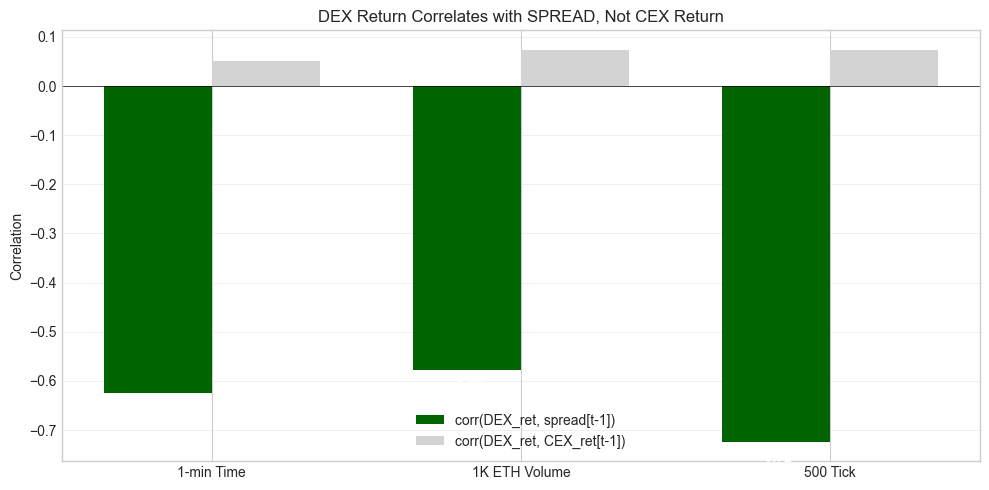

In [132]:
# Visualize: Spread correlation vs CEX return correlation
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(spread_corr_df))
width = 0.35

bars1 = ax.bar(x - width/2, spread_corr_df['corr_with_spread'], width, 
               label='corr(DEX_ret, spread[t-1])', color='darkgreen')
bars2 = ax.bar(x + width/2, spread_corr_df['corr_with_cex_return'], width,
               label='corr(DEX_ret, CEX_ret[t-1])', color='lightgray')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.set_ylabel('Correlation')
ax.set_title('DEX Return Correlates with SPREAD, Not CEX Return')
ax.set_xticks(x)
ax.set_xticklabels(['1-min Time', '1K ETH Volume', '500 Tick'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, -15), textcoords="offset points", ha='center', fontsize=10, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

### 12.2 Key Insight: Spread Correction, Not Return Prediction

**The cross-correlation of returns was weak because it asked the wrong question.**

| Correlation | Value | Interpretation |
|-------------|-------|----------------|
| corr(DEX_ret, CEX_ret[t-1]) | ~0.05 | Weak — DEX doesn't follow CEX returns |
| corr(DEX_ret, spread[t-1]) | ~-0.6 | Strong — DEX corrects the price gap |

**What this means:**
- DEX doesn't simply mimic what CEX did last period
- DEX responds to *where prices are* relative to each other (the spread)
- When DEX is above CEX, DEX falls; when DEX is below CEX, DEX rises
- This is **error correction**, not return prediction

**This reconciles Section 10 (VECM) with Section 12 (cross-correlation):**
- VECM α ≈ -0.6 measures spread correction speed
- The correlation with spread (~-0.6) matches the VECM α
- The weak return cross-correlation (~0.05) is expected — it's measuring the wrong thing

## Section 13: Spread Correction Dynamics

Now that we understand DEX corrects the spread, we explore two questions:

1. **Asymmetry**: Does DEX correct faster when overpriced (spread > 0) vs underpriced (spread < 0)?
2. **Non-linearity**: Does correction speed depend on spread magnitude?

### 13.1 Asymmetry Analysis

Does DEX correct at the same speed when overpriced vs underpriced?

- **α_above**: Correction speed when spread > 0 (DEX priced above CEX)
- **α_below**: Correction speed when spread < 0 (DEX priced below CEX)

We estimate α as the regression slope: `DEX_return[t] = α × spread[t-1] + ε`

In [133]:
# Asymmetry Analysis: α when spread > 0 vs spread < 0
from scipy.stats import linregress

asymmetry_results = []

for name, file in [('time_1m', 'candles_1m_dex_cex.parquet'),
                   ('volume_1k', 'candles_vol_fine_dex_cex.parquet'),
                   ('tick_500', 'candles_tick_fine_dex_cex.parquet')]:
    df = pd.read_parquet(file)
    
    # Compute spread and returns
    df['spread_pct'] = (df['vwap_dex'] - df['vwap_cex']) / df['vwap_cex']
    df['ret_dex'] = df['vwap_dex'].pct_change()
    df['spread_lag1'] = df['spread_pct'].shift(1)
    df = df.dropna()
    
    # Split by sign of lagged spread
    above = df[df['spread_lag1'] > 0]  # DEX overpriced
    below = df[df['spread_lag1'] < 0]  # DEX underpriced
    
    # Regression for each group
    if len(above) > 10:
        slope_above, intercept, r, p, se = linregress(above['spread_lag1'], above['ret_dex'])
    else:
        slope_above = np.nan
        
    if len(below) > 10:
        slope_below, intercept, r, p, se = linregress(below['spread_lag1'], below['ret_dex'])
    else:
        slope_below = np.nan
    
    asymmetry_results.append({
        'bar_type': name,
        'n_above': len(above),
        'n_below': len(below),
        'α_above': slope_above,
        'α_below': slope_below,
        'ratio': abs(slope_above) / abs(slope_below) if slope_below != 0 else np.nan
    })

asymmetry_df = pd.DataFrame(asymmetry_results)

print("=== Asymmetry Analysis: Correction Speed by Spread Sign ===\n")
print(asymmetry_df.to_string(index=False))
print("\n(Ratio > 1 means faster correction when DEX is overpriced)")
print("(Ratio < 1 means faster correction when DEX is underpriced)")

=== Asymmetry Analysis: Correction Speed by Spread Sign ===

 bar_type  n_above  n_below   α_above   α_below    ratio
  time_1m    20088    24522 -0.945203 -0.778239 1.214541
volume_1k      680     1197 -0.825363 -0.678774 1.215962
 tick_500      421      797 -0.983544 -1.201322 0.818718

(Ratio > 1 means faster correction when DEX is overpriced)
(Ratio < 1 means faster correction when DEX is underpriced)


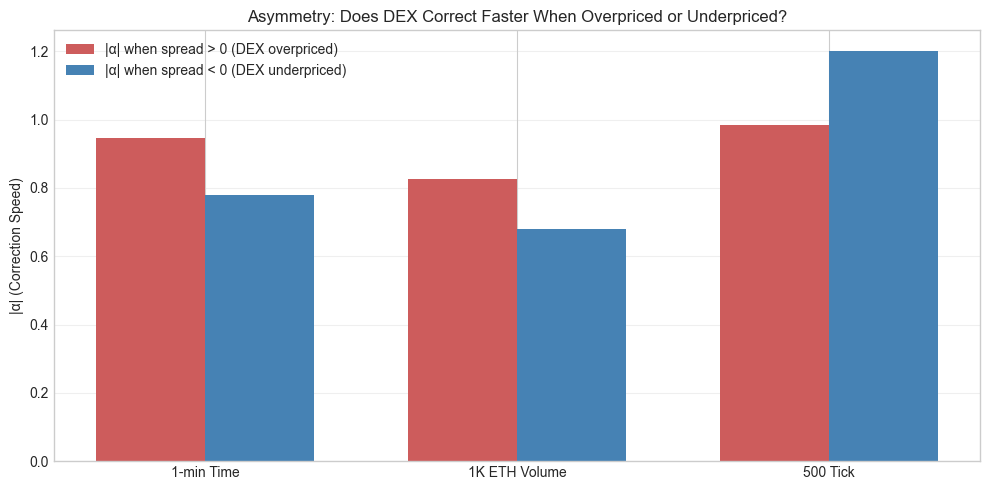

In [134]:
# Visualize asymmetry
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(asymmetry_df))
width = 0.35

# Plot absolute values for easier comparison (both should be negative)
bars1 = ax.bar(x - width/2, asymmetry_df['α_above'].abs(), width, 
               label='|α| when spread > 0 (DEX overpriced)', color='indianred')
bars2 = ax.bar(x + width/2, asymmetry_df['α_below'].abs(), width,
               label='|α| when spread < 0 (DEX underpriced)', color='steelblue')

ax.set_ylabel('|α| (Correction Speed)')
ax.set_title('Asymmetry: Does DEX Correct Faster When Overpriced or Underpriced?')
ax.set_xticks(x)
ax.set_xticklabels(['1-min Time', '1K ETH Volume', '500 Tick'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 13.2 Non-Linear Analysis

Does correction speed depend on spread magnitude? We use **average correction ratio** instead of regression:

- **Correction ratio** = -DEX_return / spread_lag1
- A ratio of 1.0 means 100% of the spread was closed in one bar
- We compute the average ratio for each quintile of |spread|

Note: Regression within quintiles is unstable due to low variance in the x-variable.

In [137]:
# Non-linear Analysis: Correction ratio by spread magnitude quintile

nonlinear_results = []

for name, file in [('time_1m', 'candles_1m_dex_cex.parquet'),
                   ('volume_1k', 'candles_vol_fine_dex_cex.parquet'),
                   ('tick_500', 'candles_tick_fine_dex_cex.parquet')]:
    df = pd.read_parquet(file)
    
    # Compute spread and returns
    df['spread_pct'] = (df['vwap_dex'] - df['vwap_cex']) / df['vwap_cex']
    df['ret_dex'] = df['vwap_dex'].pct_change()
    df['spread_lag1'] = df['spread_pct'].shift(1)
    df['abs_spread_lag1'] = df['spread_lag1'].abs()
    df = df.dropna()
    
    # Filter out near-zero spreads to avoid division issues
    df = df[df['abs_spread_lag1'] > 1e-6]
    
    # Compute correction ratio: how much of the spread was closed?
    # If spread[t-1] > 0 and DEX goes down (negative return), that's correction
    # correction_ratio = -ret_dex / spread_lag1 (positive = correction toward CEX)
    df['correction_ratio'] = -df['ret_dex'] / df['spread_lag1']
    
    # Clip extreme values (outliers from small spreads)
    df['correction_ratio'] = df['correction_ratio'].clip(-2, 2)
    
    # Assign quintiles by absolute spread
    df['quintile'] = pd.qcut(df['abs_spread_lag1'], q=5, 
                             labels=['Q1 (Smallest)', 'Q2', 'Q3', 'Q4', 'Q5 (Largest)'])
    
    # Average correction ratio for each quintile
    for q in ['Q1 (Smallest)', 'Q2', 'Q3', 'Q4', 'Q5 (Largest)']:
        subset = df[df['quintile'] == q]
        if len(subset) > 10:
            avg_correction = subset['correction_ratio'].mean()
            median_correction = subset['correction_ratio'].median()
            avg_spread = subset['abs_spread_lag1'].mean() * 100 * 100  # basis points
            nonlinear_results.append({
                'bar_type': name,
                'quintile': q,
                'n': len(subset),
                'avg_spread_bps': avg_spread,
                'avg_correction_ratio': avg_correction,
                'median_correction_ratio': median_correction
            })

nonlinear_df = pd.DataFrame(nonlinear_results)

print("=== Non-Linear Analysis: Correction Ratio by Spread Magnitude ===")
print("(Correction ratio ≈ 1.0 means 100% of spread closed in one bar)\n")

for name in ['time_1m', 'volume_1k', 'tick_500']:
    subset = nonlinear_df[nonlinear_df['bar_type'] == name]
    print(f"--- {name} ---")
    print(subset[['quintile', 'n', 'avg_spread_bps', 'avg_correction_ratio', 'median_correction_ratio']].to_string(index=False))
    print()


=== Non-Linear Analysis: Correction Ratio by Spread Magnitude ===
(Correction ratio ≈ 1.0 means 100% of spread closed in one bar)

--- time_1m ---
     quintile    n  avg_spread_bps  avg_correction_ratio  median_correction_ratio
Q1 (Smallest) 8889        0.275333              0.031538                 0.381737
           Q2 8889        0.830162              0.099065                 0.402202
           Q3 8888        1.514564              0.214817                 0.548090
           Q4 8889        2.627537              0.340677                 0.613373
 Q5 (Largest) 8889       22.637474              0.627923                 0.905748

--- volume_1k ---
     quintile   n  avg_spread_bps  avg_correction_ratio  median_correction_ratio
Q1 (Smallest) 376        1.349000             -0.089076                -2.000000
           Q2 375        4.619604              0.104109                 0.920072
           Q3 375        9.652996              0.137515                 0.429672
           Q4 375 

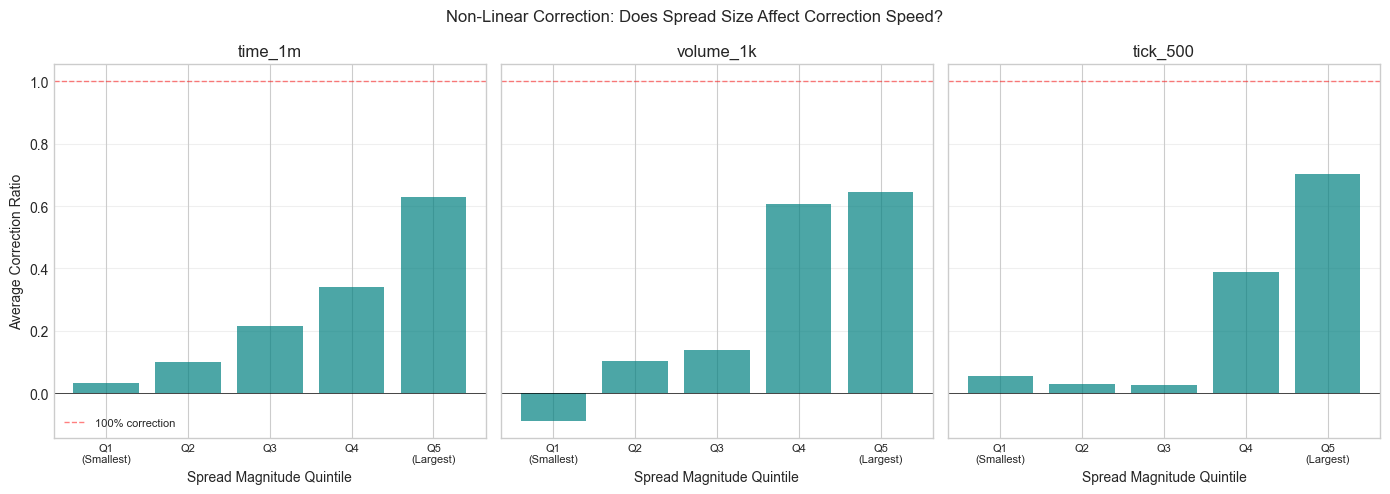

In [138]:
# Visualize: Correction ratio by spread quintile for each bar type
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for idx, name in enumerate(['time_1m', 'volume_1k', 'tick_500']):
    subset = nonlinear_df[nonlinear_df['bar_type'] == name].copy()
    
    # Sort by quintile order
    quintile_order = ['Q1 (Smallest)', 'Q2', 'Q3', 'Q4', 'Q5 (Largest)']
    subset['quintile'] = pd.Categorical(subset['quintile'], categories=quintile_order, ordered=True)
    subset = subset.sort_values('quintile')
    
    x = range(len(subset))
    axes[idx].bar(x, subset['avg_correction_ratio'], color='teal', alpha=0.7)
    axes[idx].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].axhline(y=1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='100% correction')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels([q.replace(' ', '\n') for q in quintile_order], fontsize=8)
    axes[idx].set_xlabel('Spread Magnitude Quintile')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True, alpha=0.3, axis='y')
    if idx == 0:
        axes[idx].legend(fontsize=8)

axes[0].set_ylabel('Average Correction Ratio')
fig.suptitle('Non-Linear Correction: Does Spread Size Affect Correction Speed?', fontsize=12)
plt.tight_layout()
plt.show()


### 13.3 Summary: Spread Correction Dynamics

**Asymmetry Analysis:**
- Compares |α_above| vs |α_below| to see if DEX corrects faster when overpriced or underpriced
- Asymmetry suggests directional differences in arbitrage ease (e.g., selling vs buying pressure)

**Non-Linear Analysis:**
- Uses correction ratio = -DEX_return / spread_lag1 instead of regression
- Ratio of 1.0 means the spread was fully closed in one bar
- If ratio increases from Q1 → Q5: larger spreads attract faster arbitrage
- If ratio is near 0 for Q1: small spreads don't trigger correction (transaction costs dominate)